In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity, legend
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    get_biological_age,
    masked_xval,
    stratified_xval,
    fit_model,
    expected_counts
)
from itertools import product
from sklearn.preprocessing import OneHotEncoder
from toolz import pluck

In [2]:
warnings.simplefilter("ignore")
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

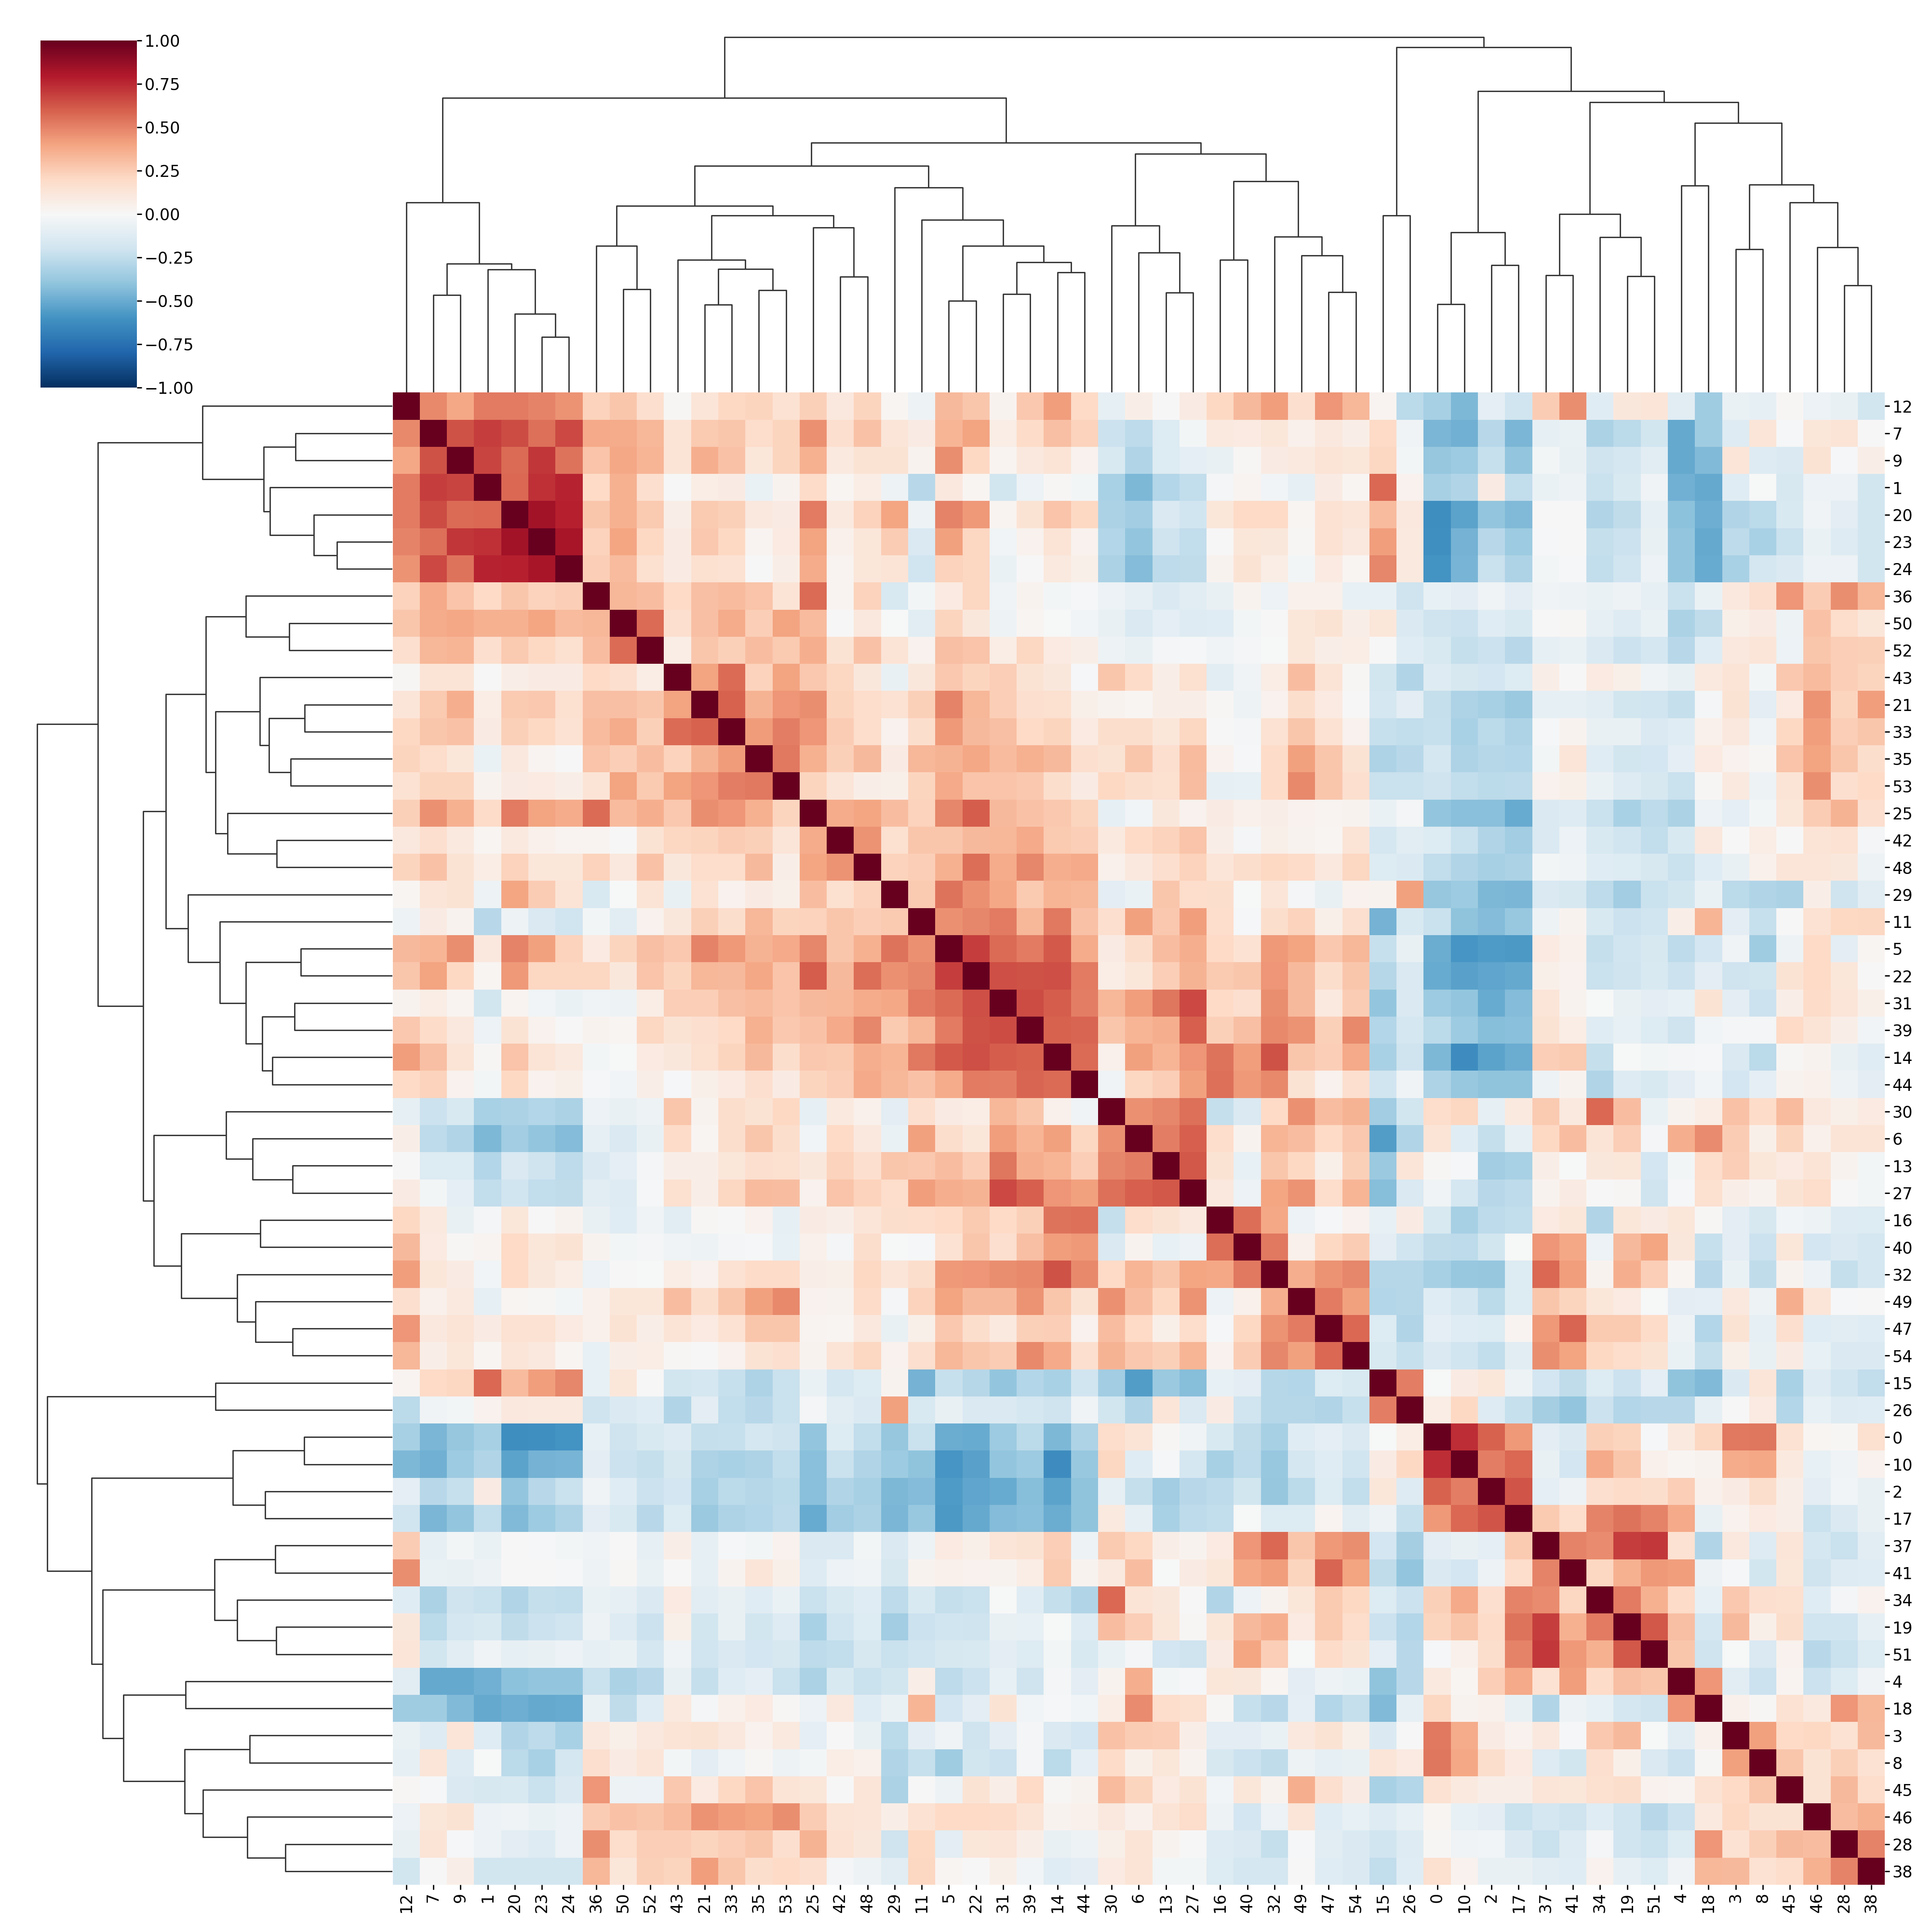

In [5]:
sns.clustermap(df.iloc[:, :n_syllables].corr(), cmap='RdBu_r', vmin=-1)

In [5]:
pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
size_df = pd.read_parquet(pth)

In [6]:
sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
# sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

## Run held-out fitting to determine number of splines

In [8]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 26,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 500,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 20,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 150,
}

output = fit_model(features, hypparams, 2)

In [9]:
pred_exp_counts = expected_counts(output['concentrations'][0], jnp.tile(features['counts'][:1], (hypparams["n_age_samples"], 1)).sum(axis=1))

In [10]:
age_samples = output['init_components'].age_samples
age_samples = output['init_components'].age_unnormalizer(age_samples)

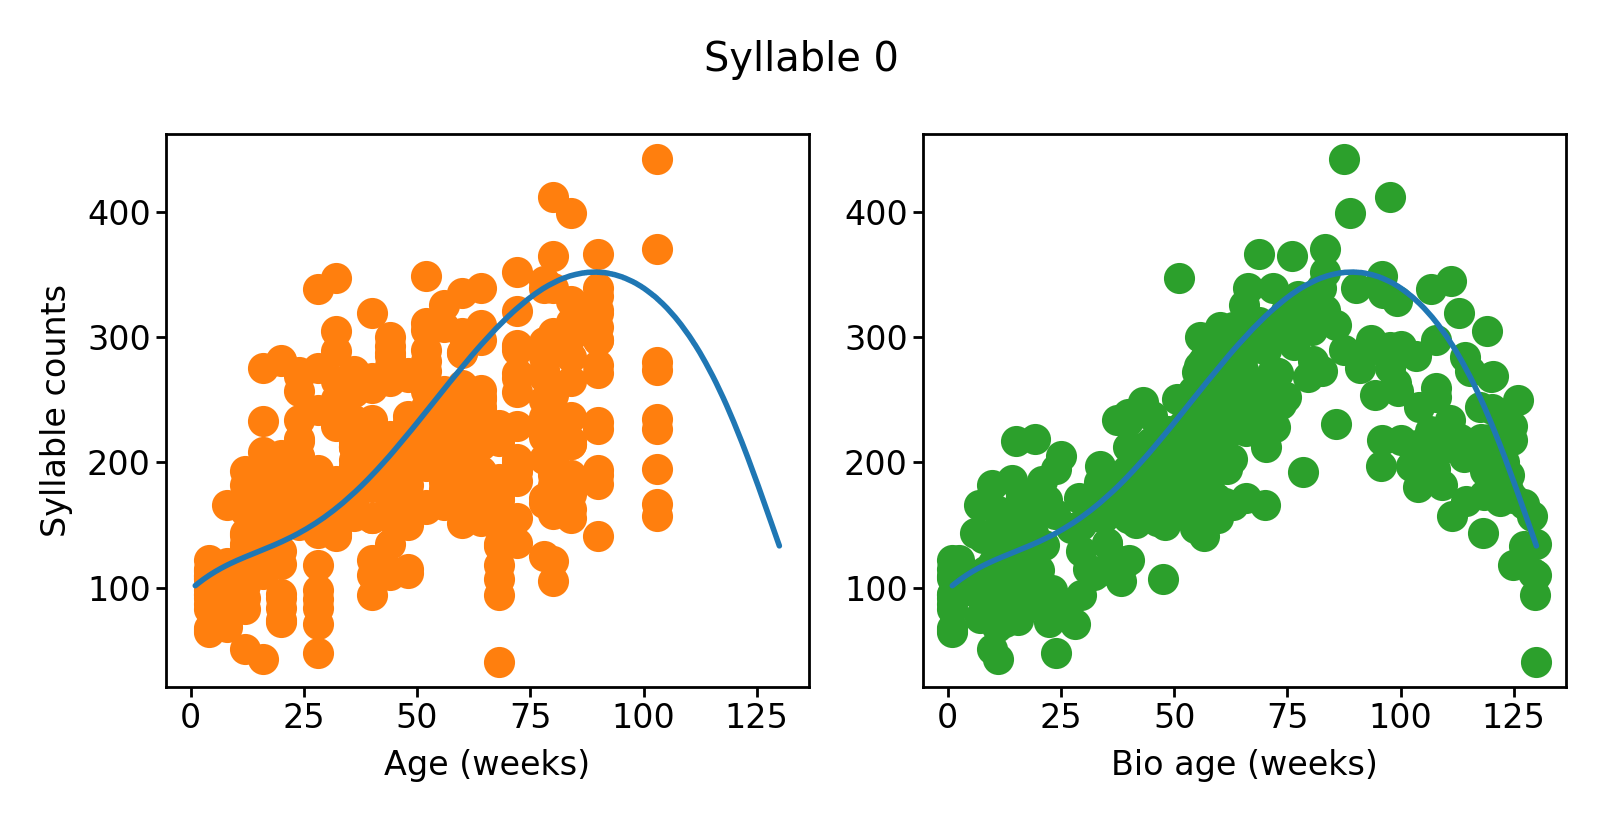

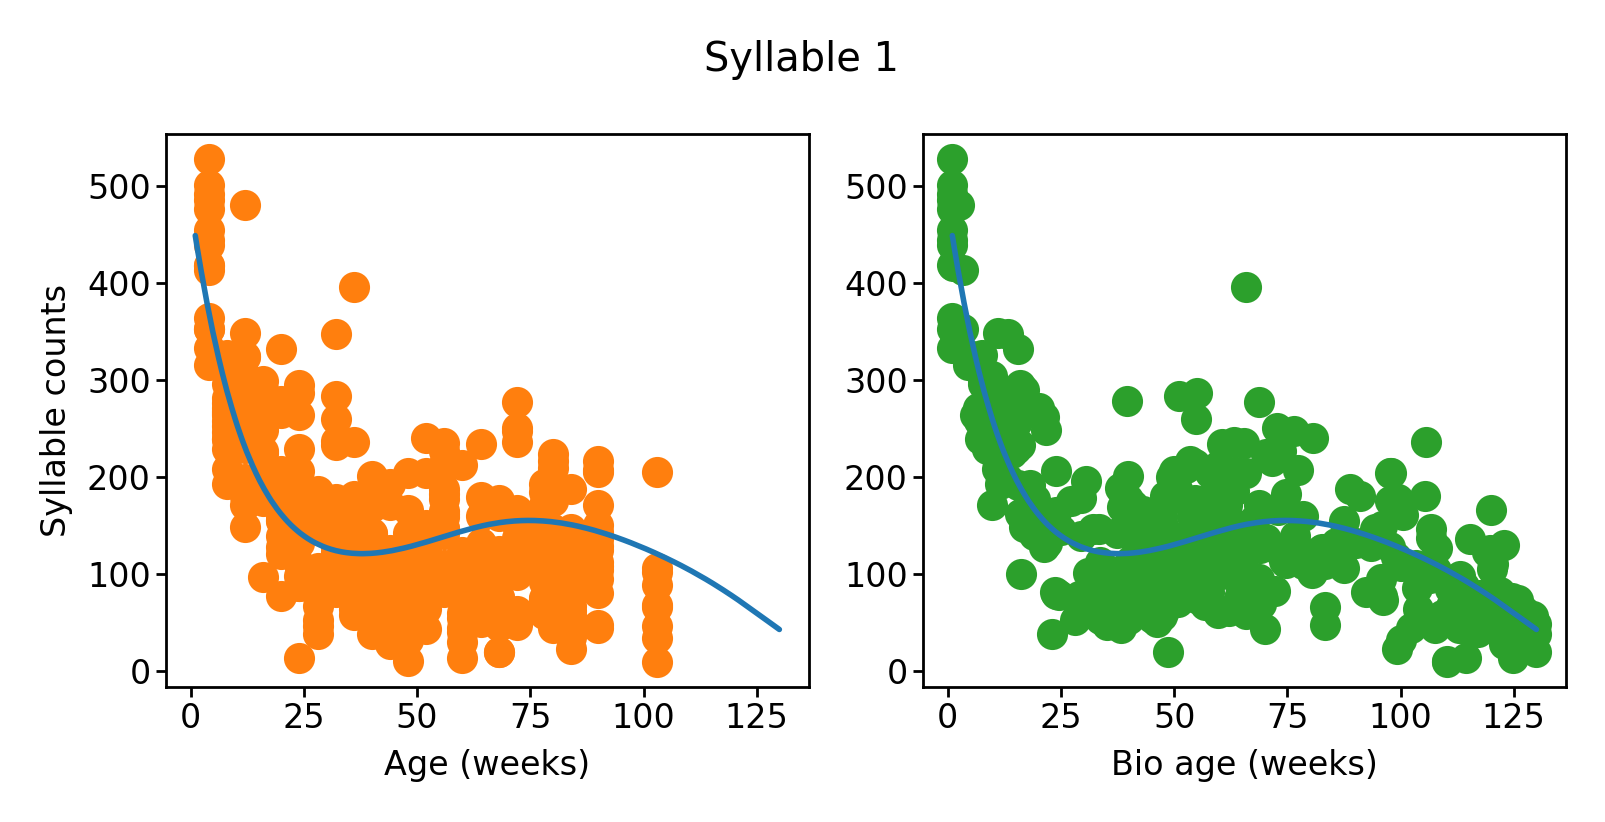

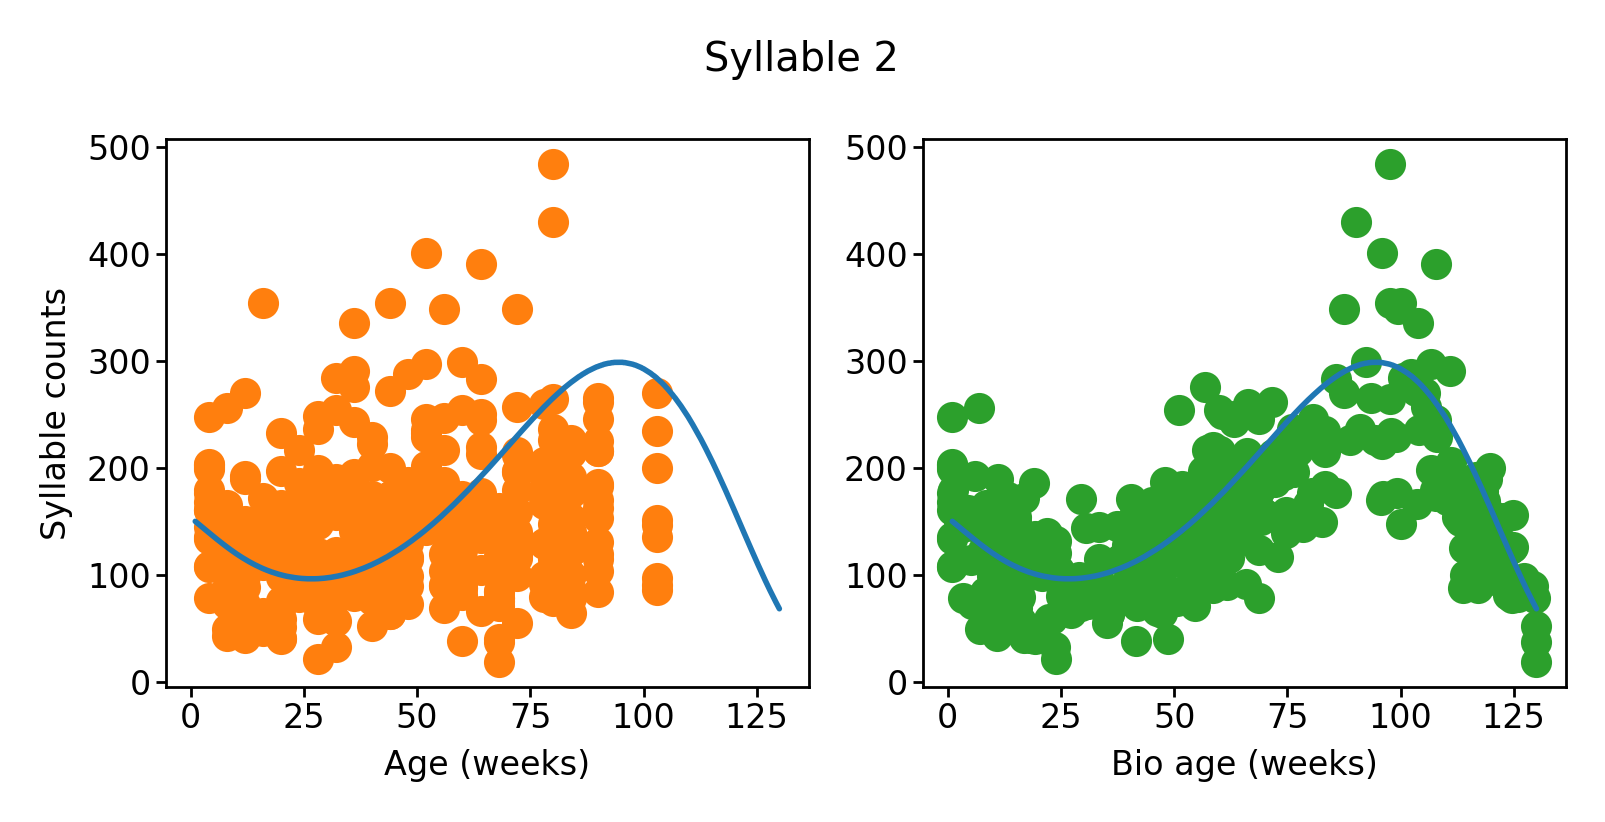

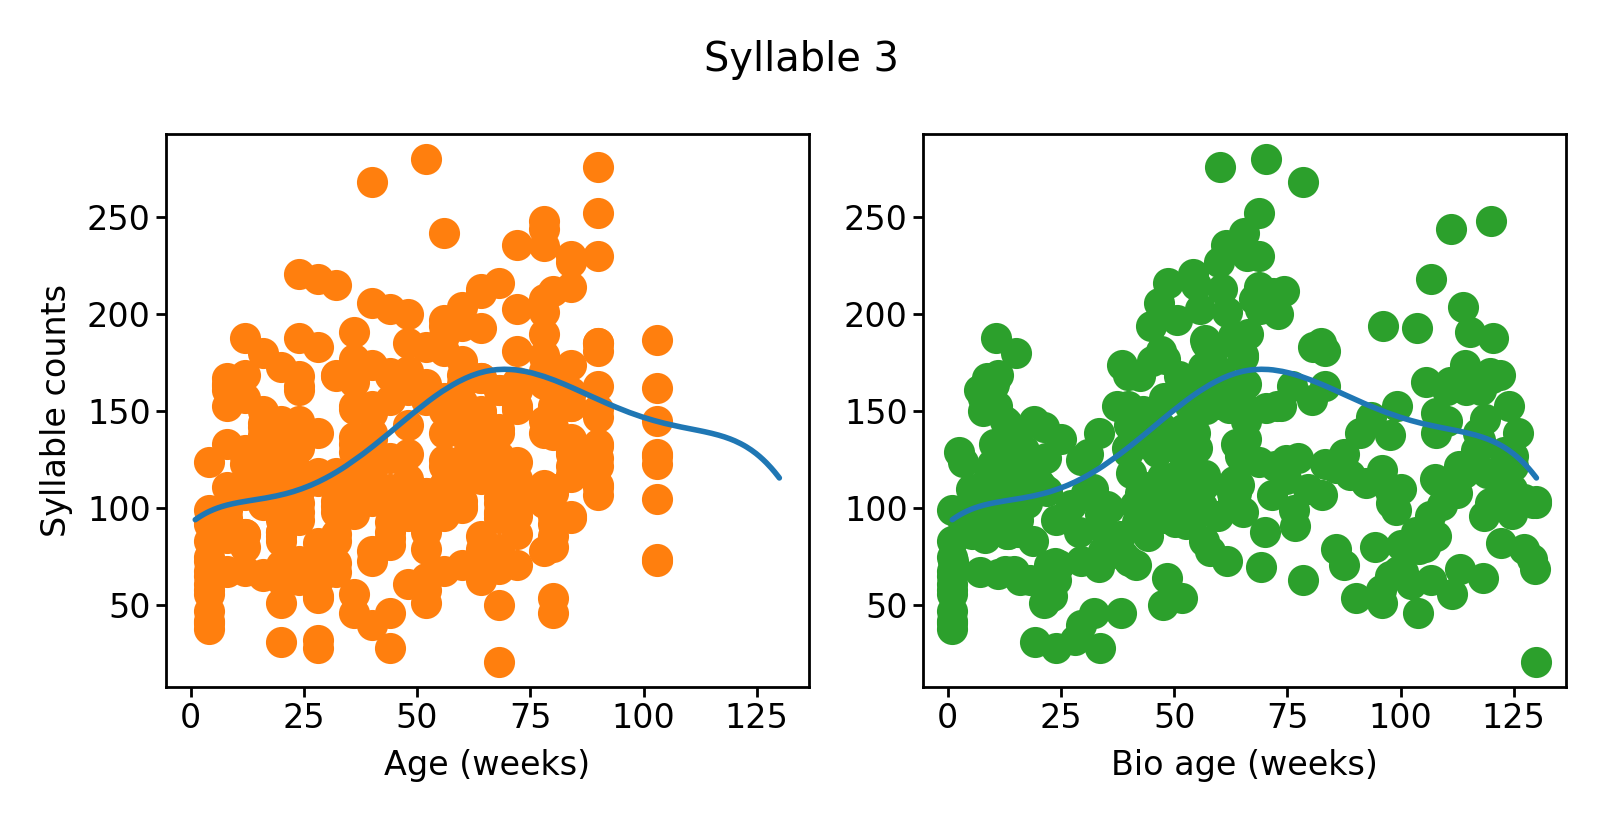

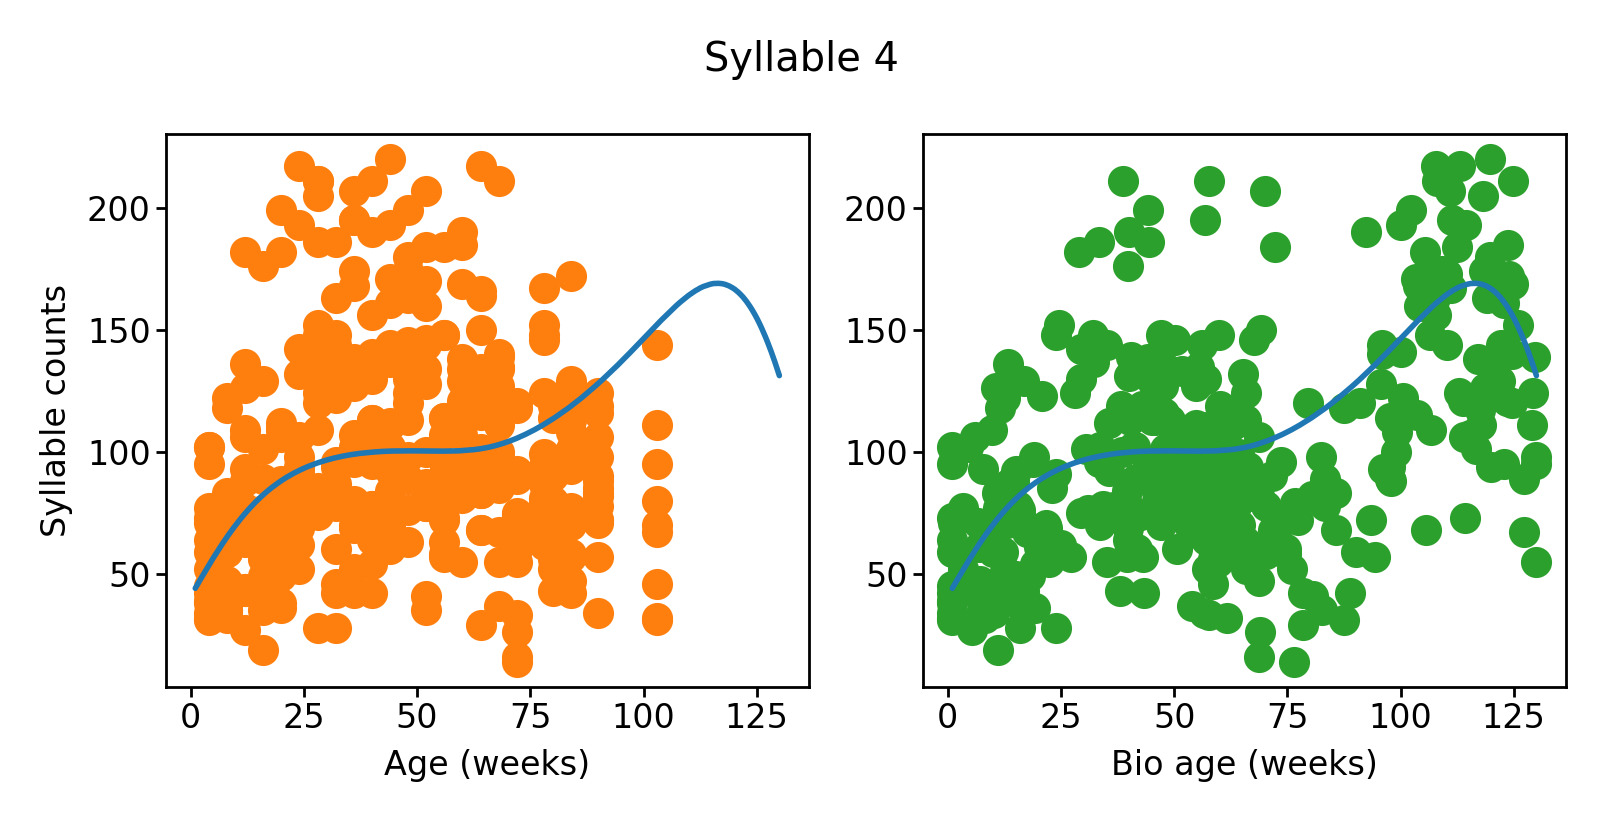

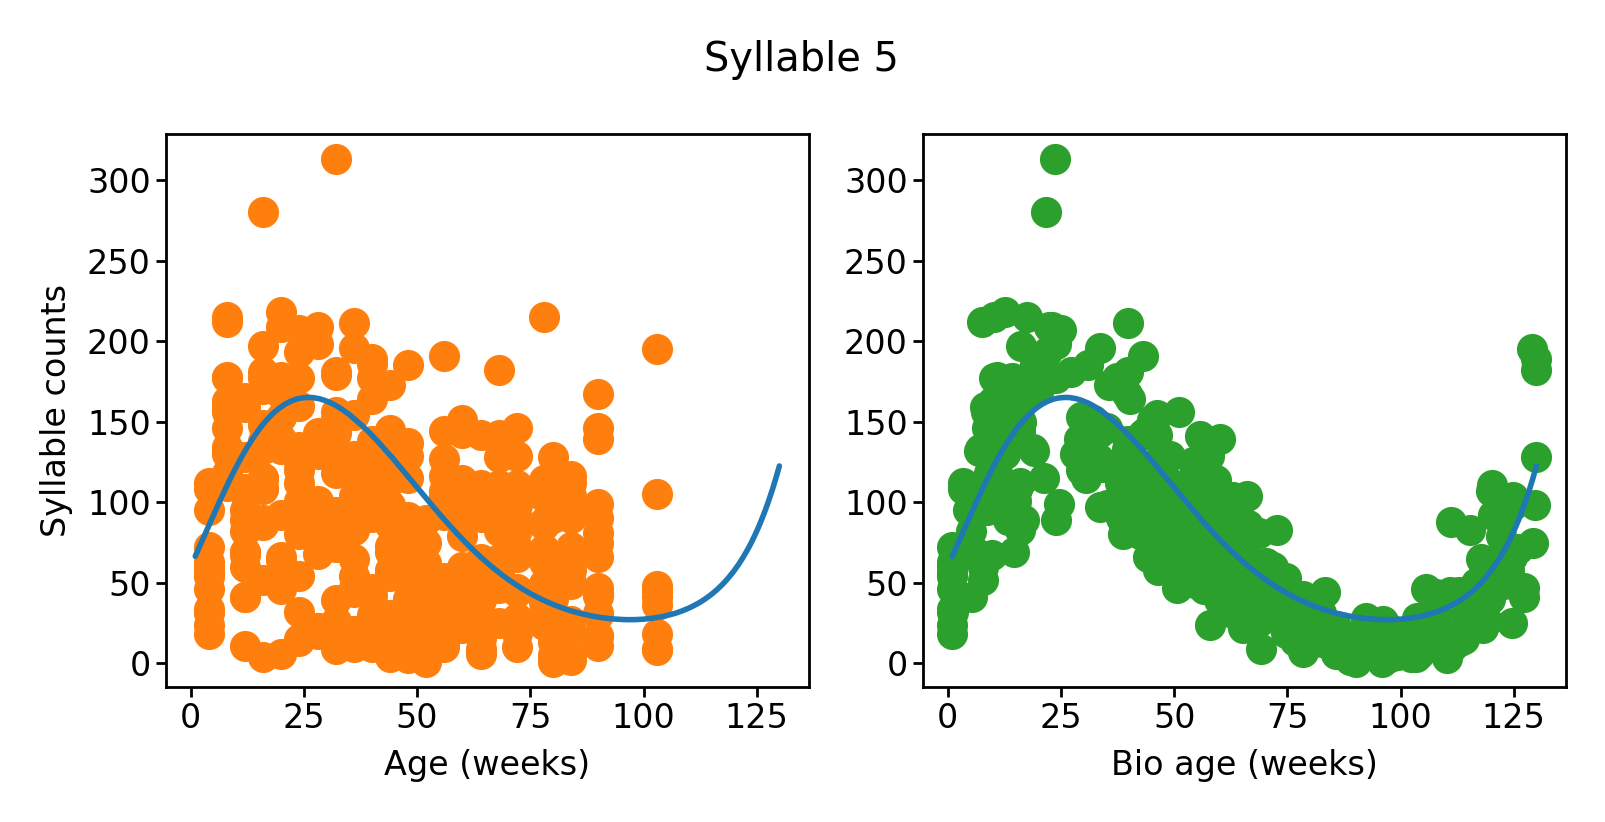

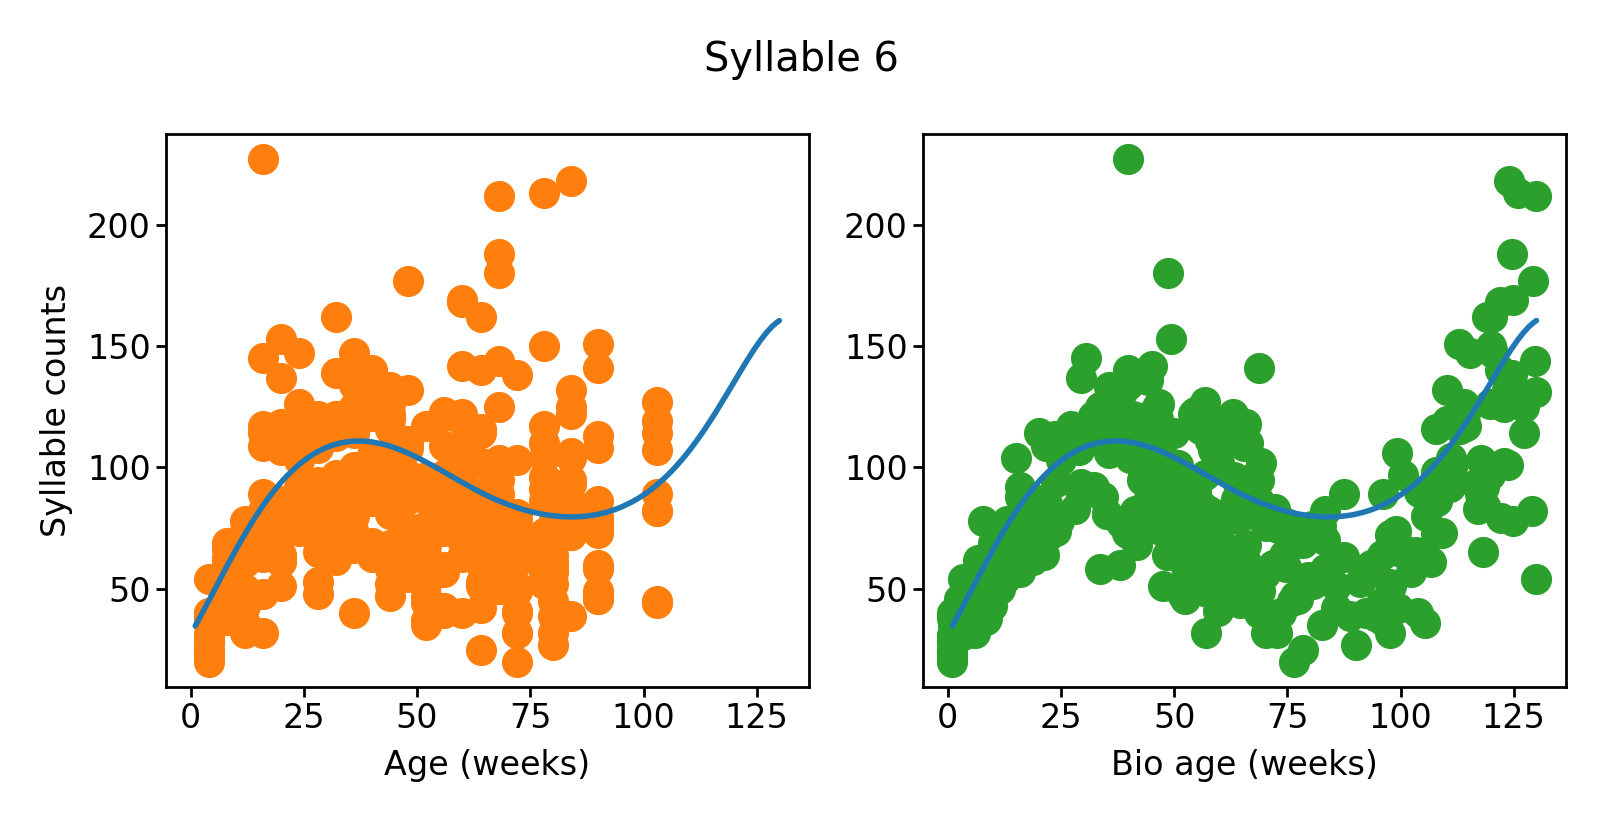

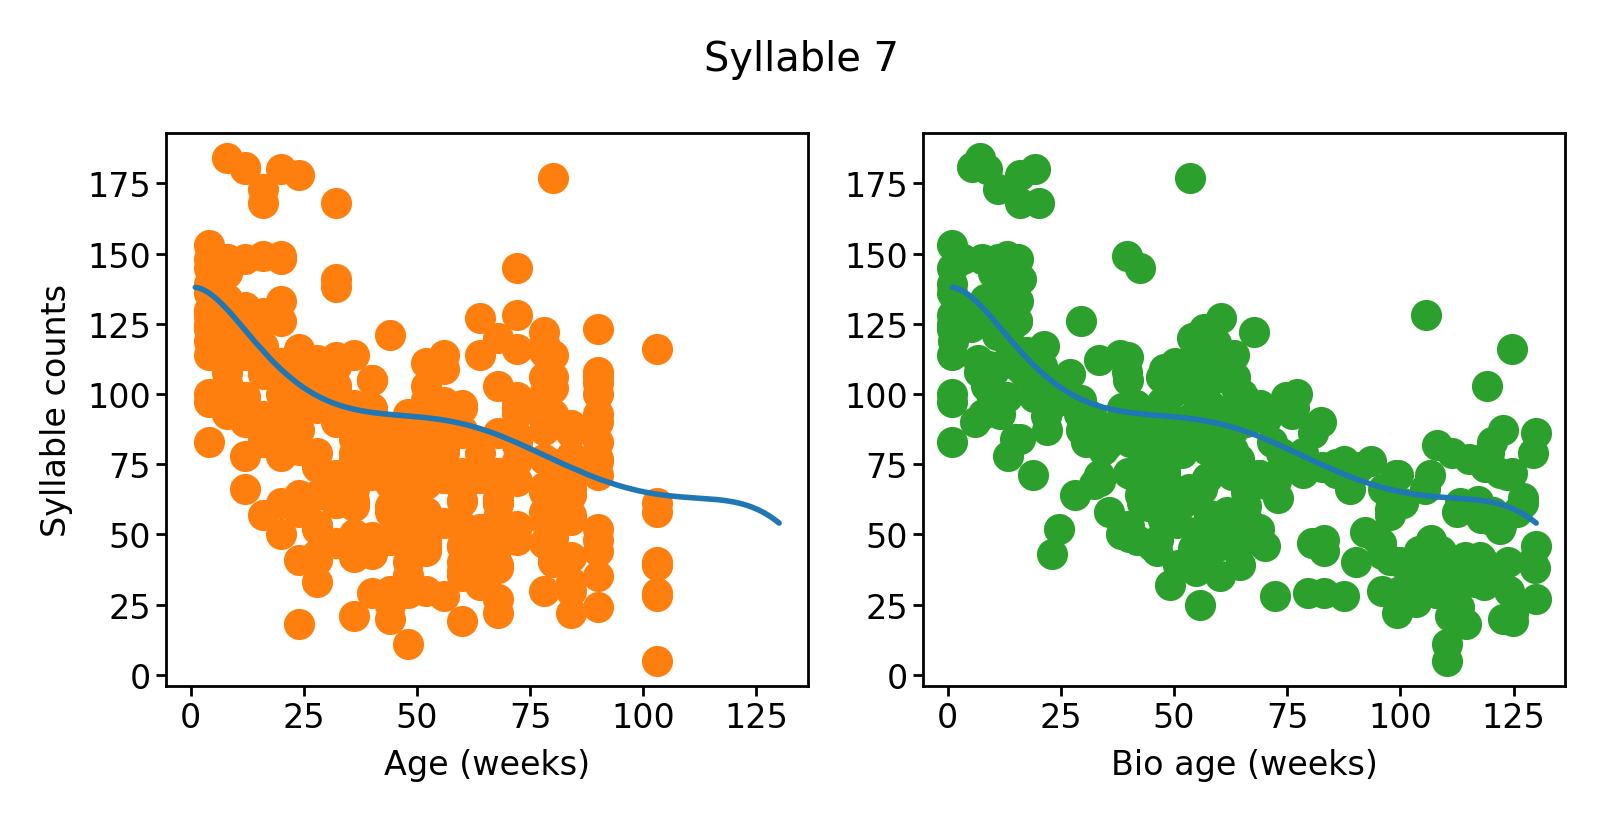

In [11]:
for syllable in range(8):
    fig, ax = plt.subplots(1, 2, figsize=(4, 2))
    
    ax[0].plot(age_samples, pred_exp_counts[:, syllable])
    ax[0].scatter(features['ages'], features['counts'][:, syllable], color='C1')
    ax[0].set(xlabel="Age (weeks)", ylabel="Syllable counts")
    ax[1].plot(age_samples, pred_exp_counts[:, syllable])
    ax[1].scatter(output['bio_ages'], features['counts'][:, syllable], color='C2')
    ax[1].set(xlabel="Bio age (weeks)")
    fig.suptitle(f"Syllable {syllable}")
    fig.tight_layout()

In [12]:
output = masked_xval(features, hypparams, 2, n_repeats=3)

In [13]:
list(pluck('heldout_r2_total', output.values()))

[0.4984016736476429, 0.5034515970928115, 0.5000996438656934]

In [7]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 26,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 40,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 150,
}

# output = fit_model(features, hypparams, model_version=1)
model_version_output = {}
for v in range(3):
    if v == 0:
        hypparams['bio_params_sd'] = 10
    else:
        hypparams['bio_params_sd'] = 0.3
    model_version_output[v] = masked_xval(features, hypparams, model_version=v, n_repeats=3)
    print("version", v, list(pluck('heldout_r2_total', model_version_output[v].values())))

version 0 [0.43921166638003234, 0.46336973440187296, 0.4724060277172172]
version 1 [0.5998493865679827, 0.6042927922863026, 0.6166133729013298]
version 2 [0.6321283968062187, 0.6397702256511282, 0.6366247046727165]


In [12]:
# df.set_index(pd.Index(output['bio_ages'], name="bio_age"), append=True).to_parquet("/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_with_bioage_v00.parquet")

In [19]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 10,  # weeks
    "bio_params_sd": 0.3,
    "n_age_samples": 500,
    "n_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 40,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 125,
}

lls = {}
bio_ages = {}
# for n_splines in tqdm(range(4, 8, 1)):
for age_sd in tqdm(list(map(float, np.linspace(2, 100, 13)))):
    # hypparams["n_splines"] = n_splines
    hypparams["age_sd"] = age_sd
    output = masked_xval(features, hypparams, model_version=1, n_repeats=5)
    hll = list(pluck('heldout_ll', output.values()))
    # lls[n_splines] = np.array(hll)
    lls[age_sd] = np.array(hll)
    bio_ages[age_sd] = list(pluck("bio_ages", output.values()))

  0%|          | 0/13 [00:00<?, ?it/s]

In [13]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 20,  # weeks
    "bio_params_sd": 0.3,
    "n_age_samples": 500,
    "n_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 40,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 125,
}

output = stratified_xval(features, hypparams, model_version=1, n_folds=5)

In [15]:
m1_lls = list(pluck('heldout_ll', output.values()))

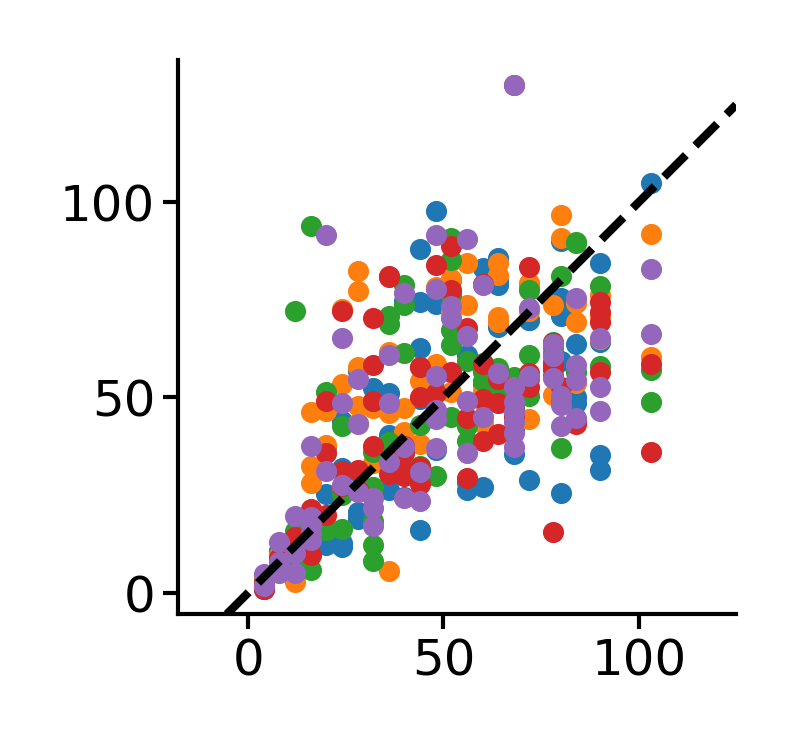

In [14]:
fig = figure(1.2, 1.2)
for k, v in output.items():
    plt.scatter(v['true_ages'], v['bio_ages'], s=3)
add_identity(plt.gca(), ls='--', c='k')
plt.axis('equal')
sns.despine()

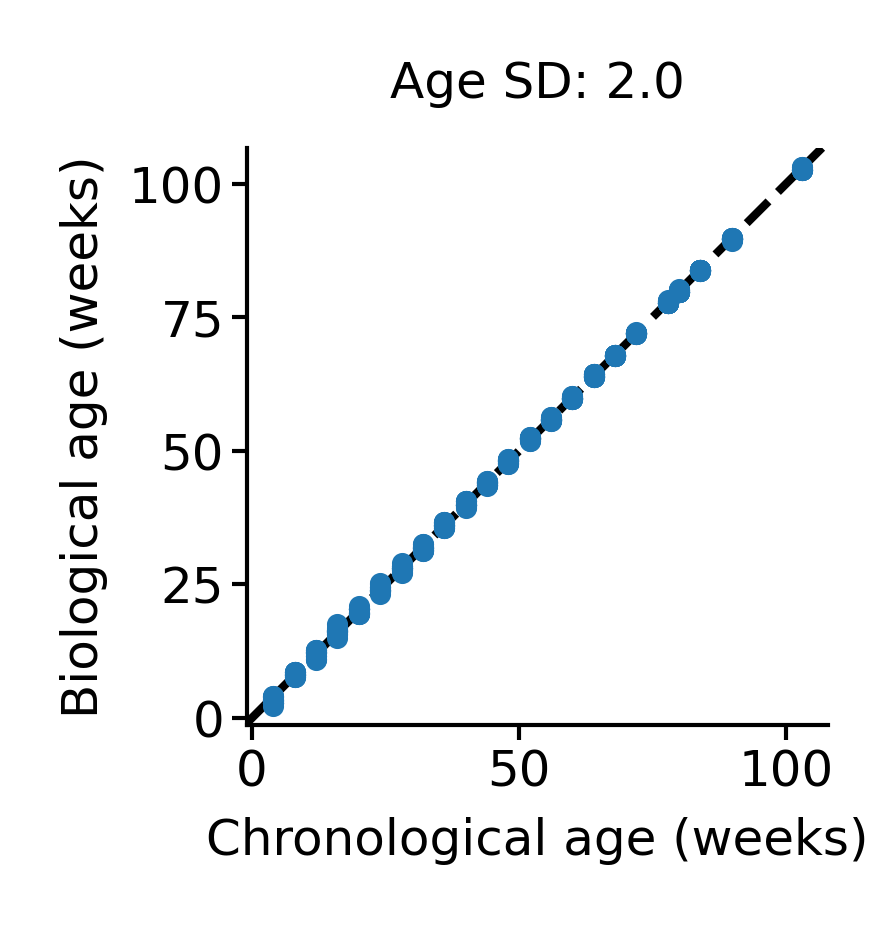

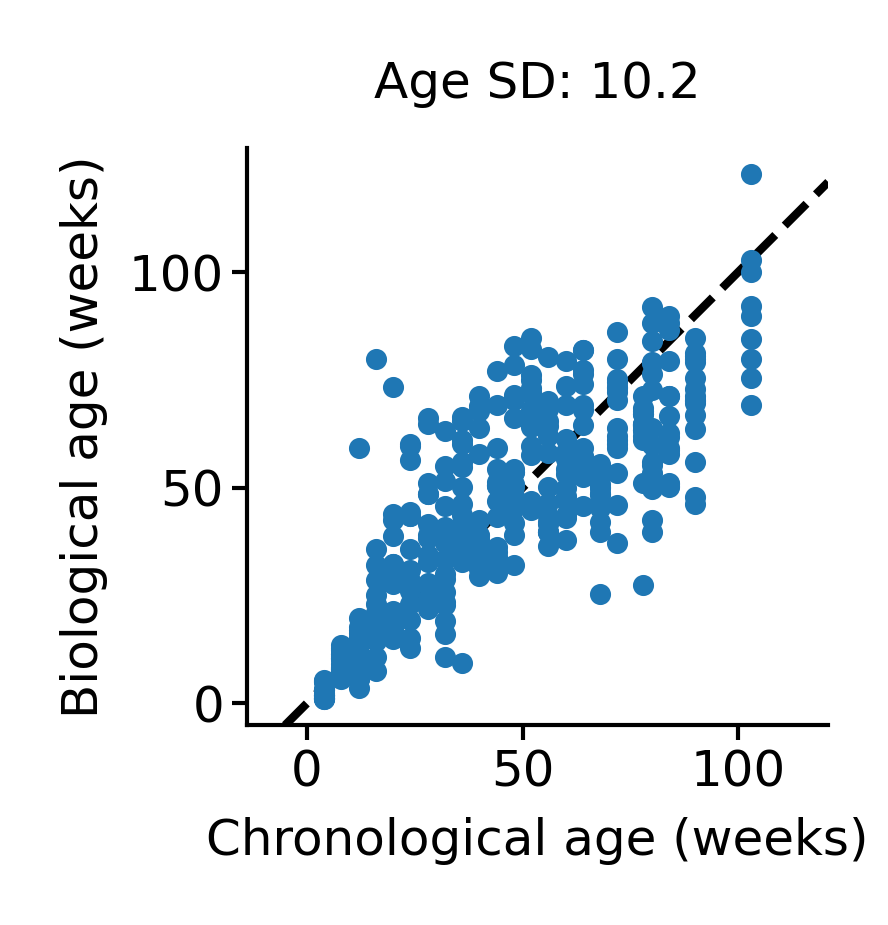

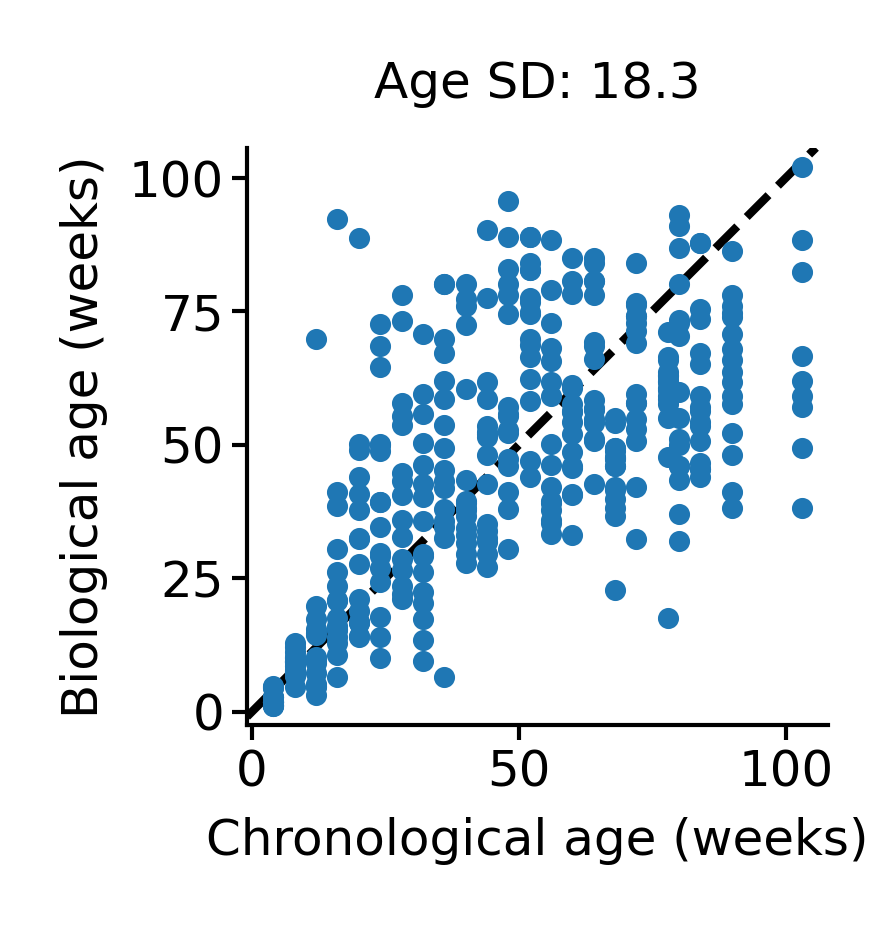

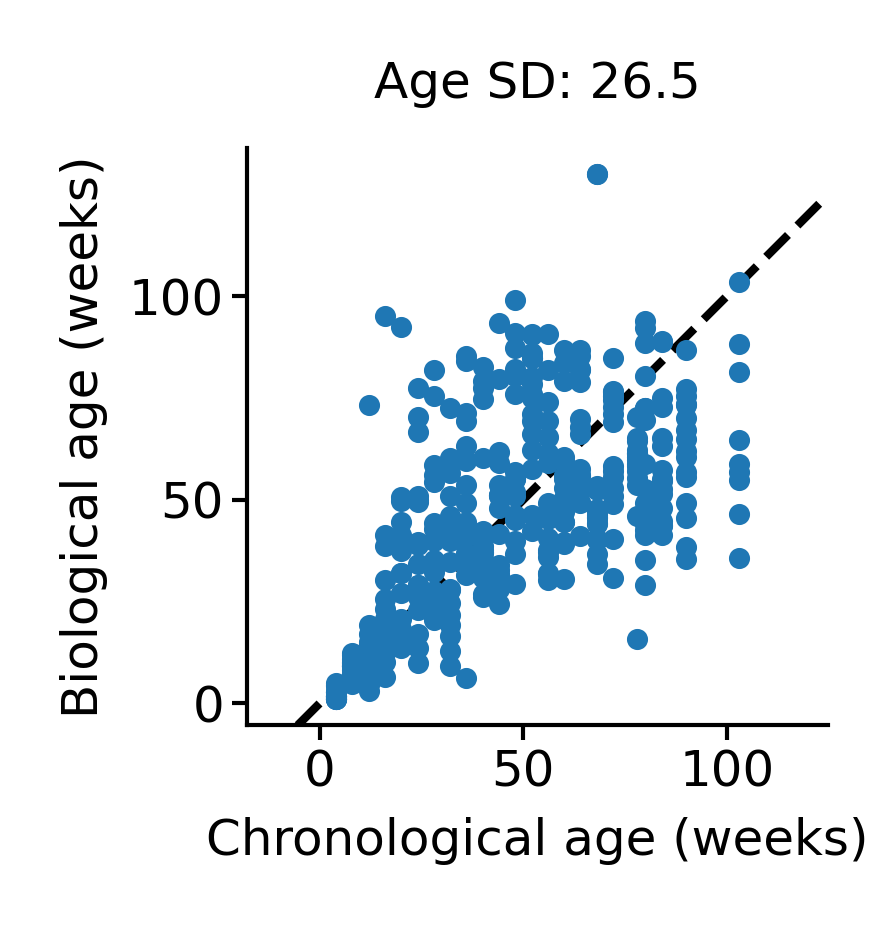

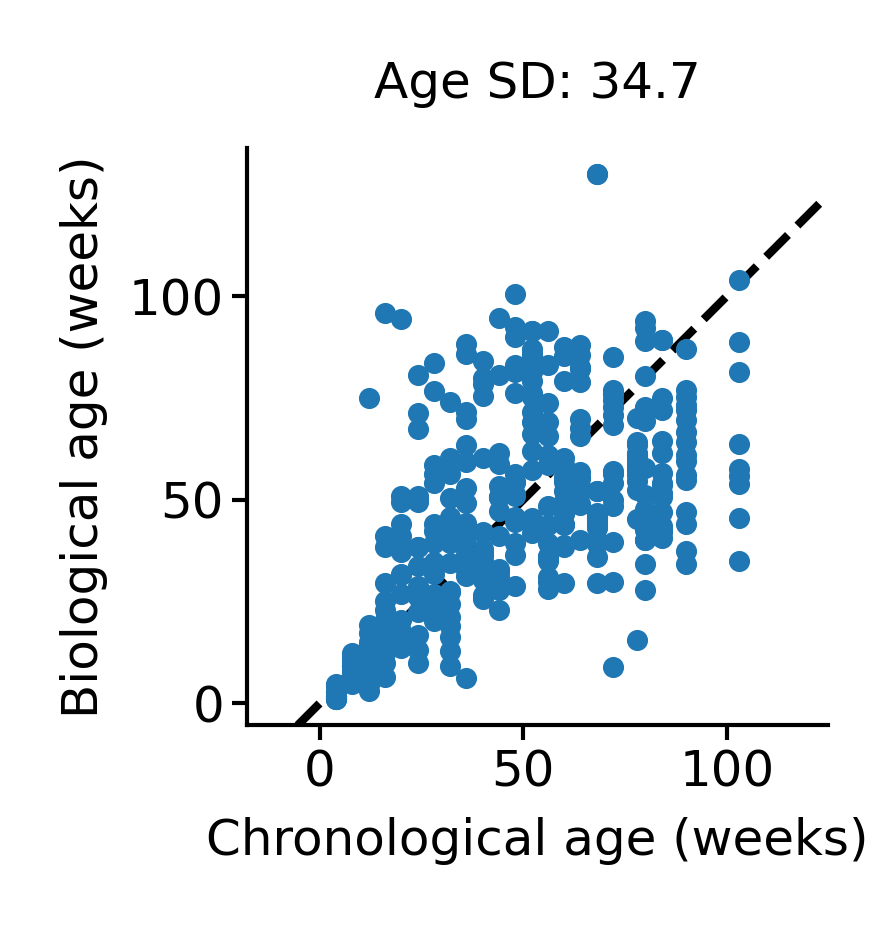

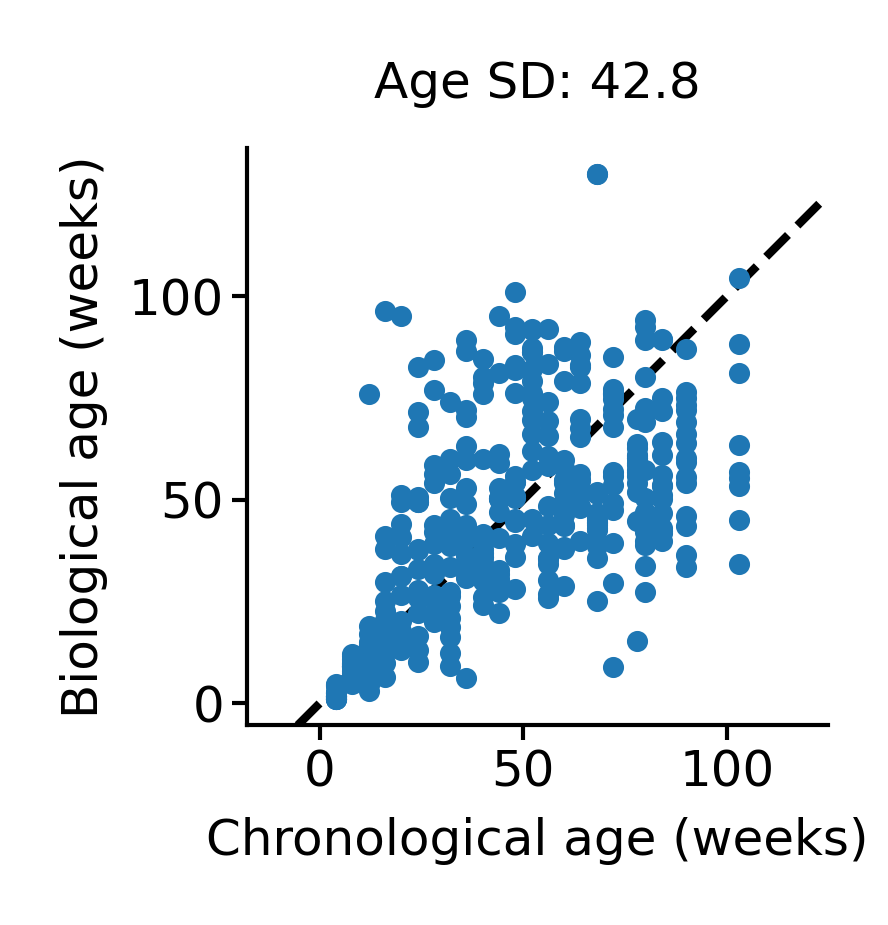

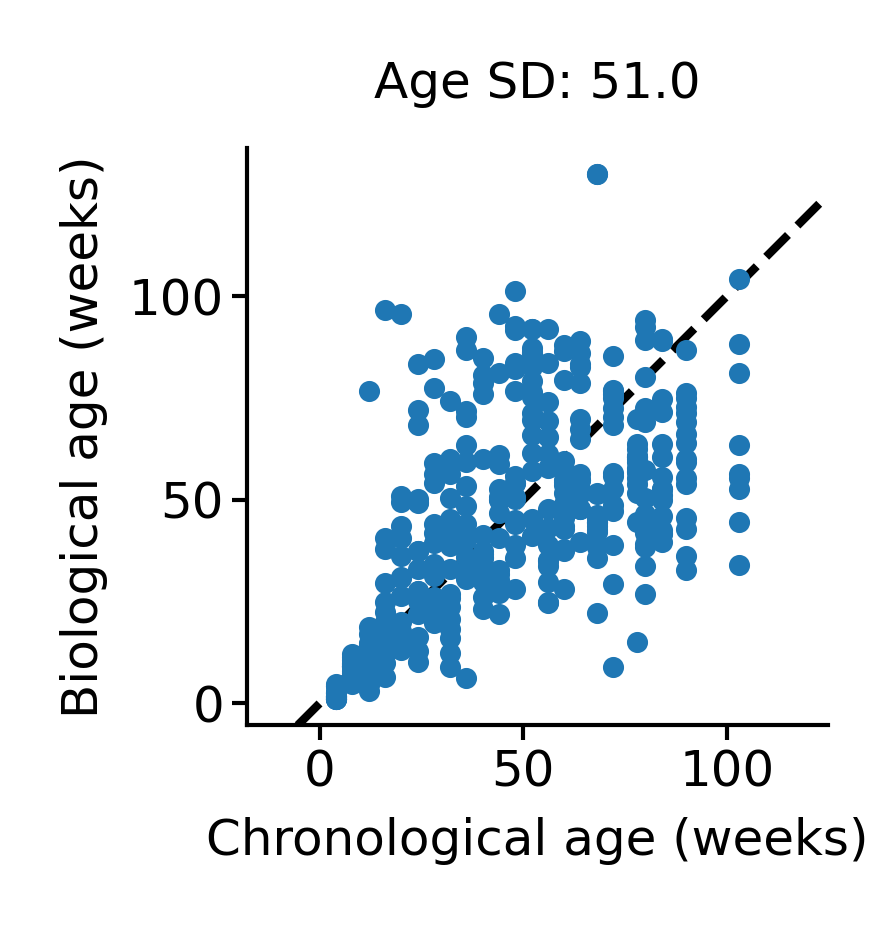

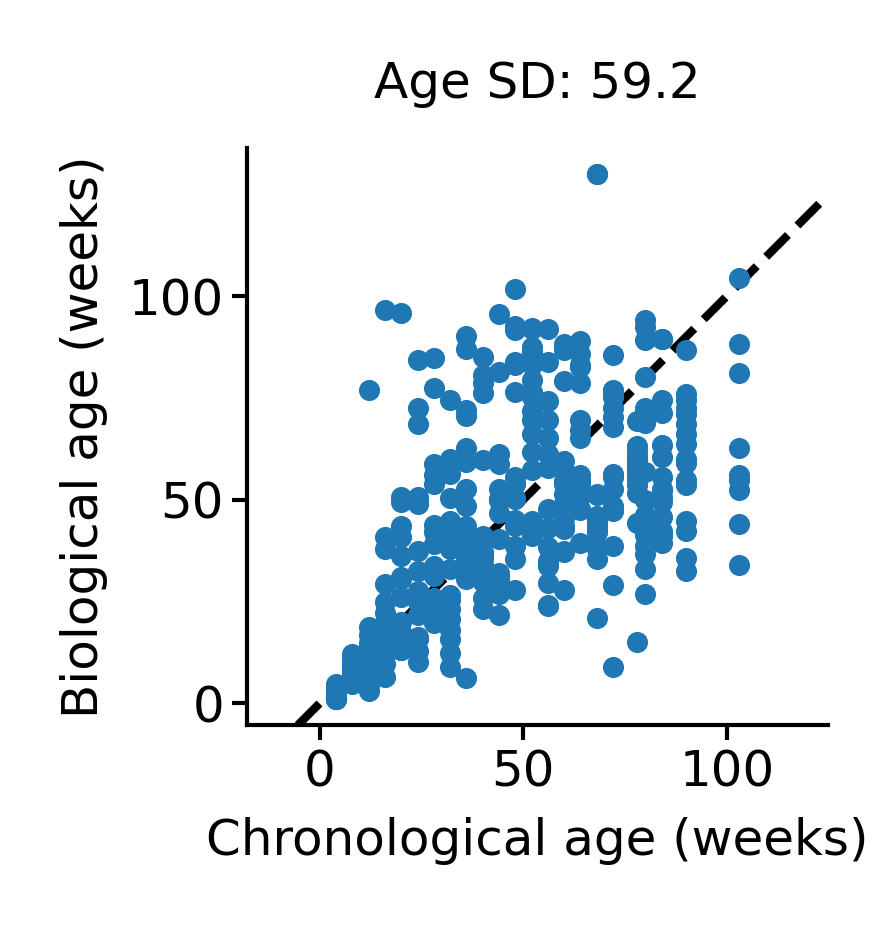

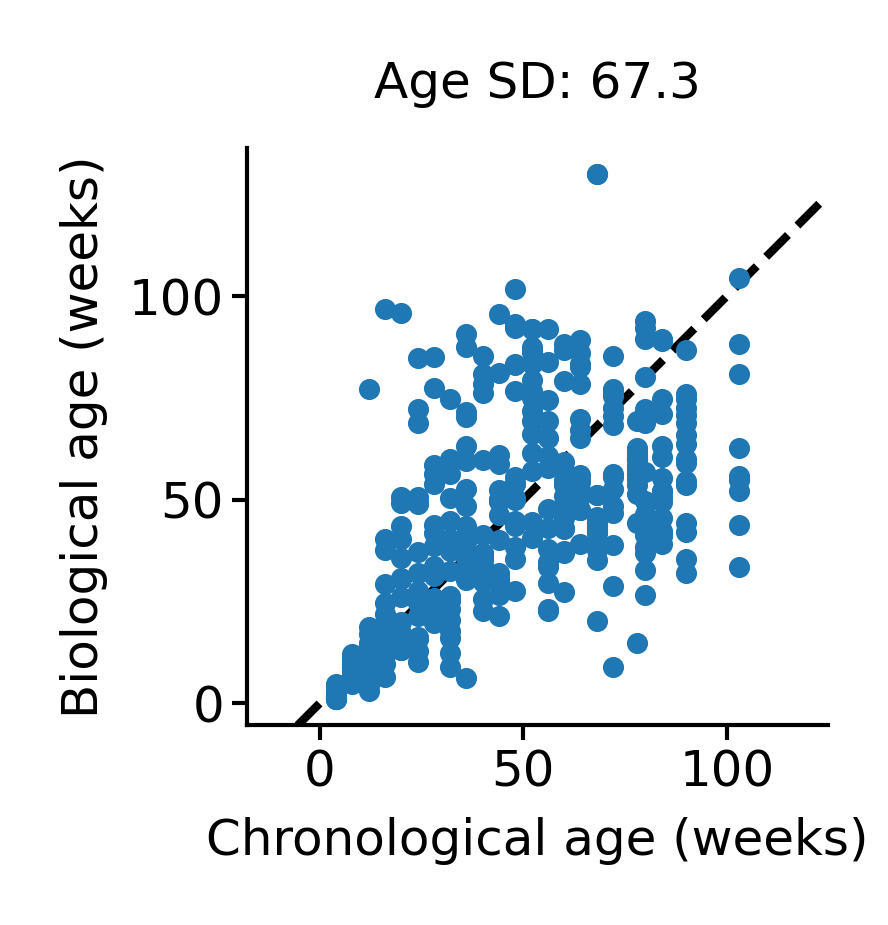

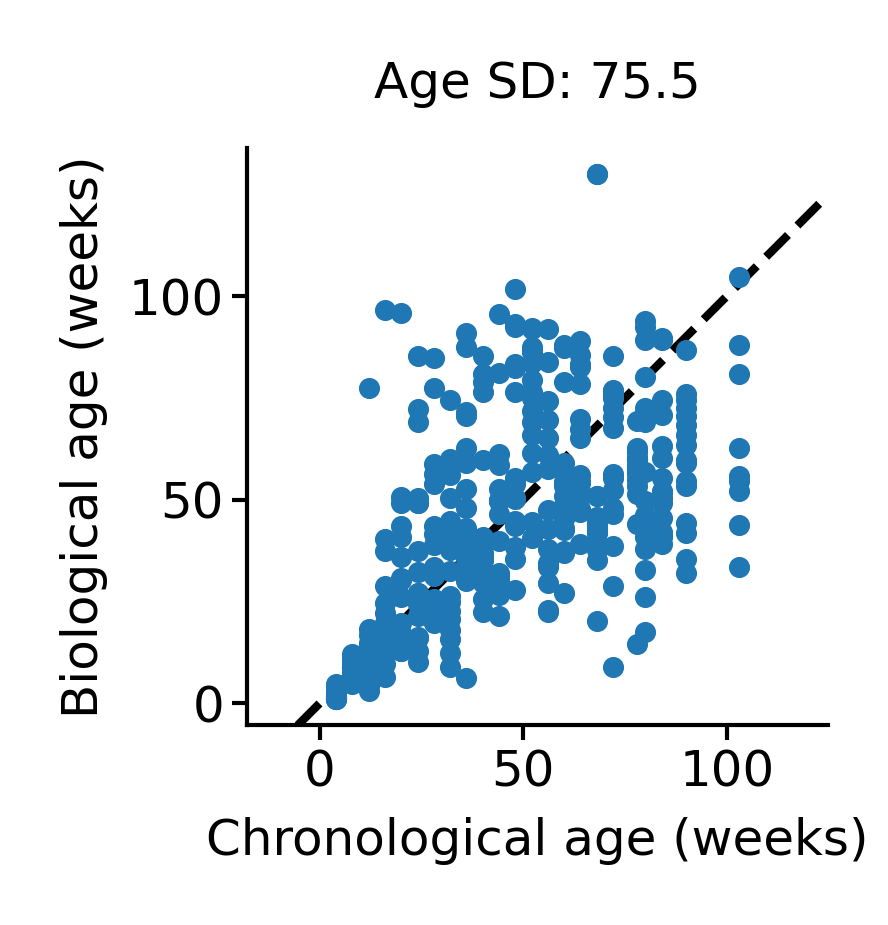

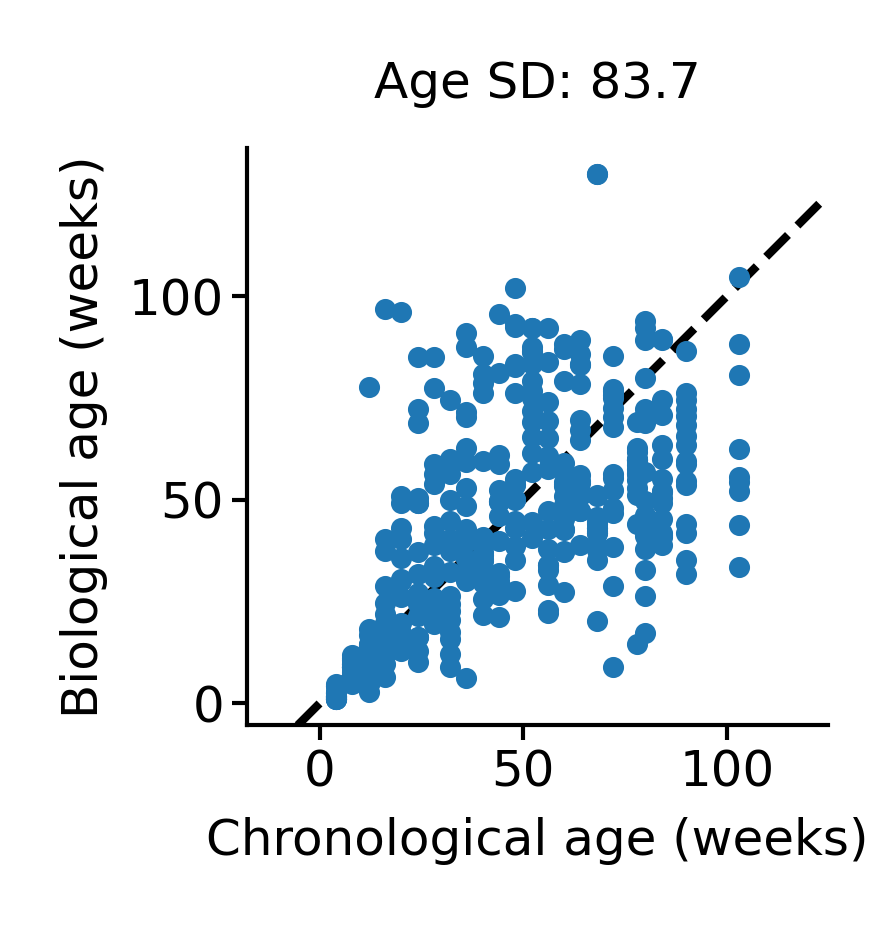

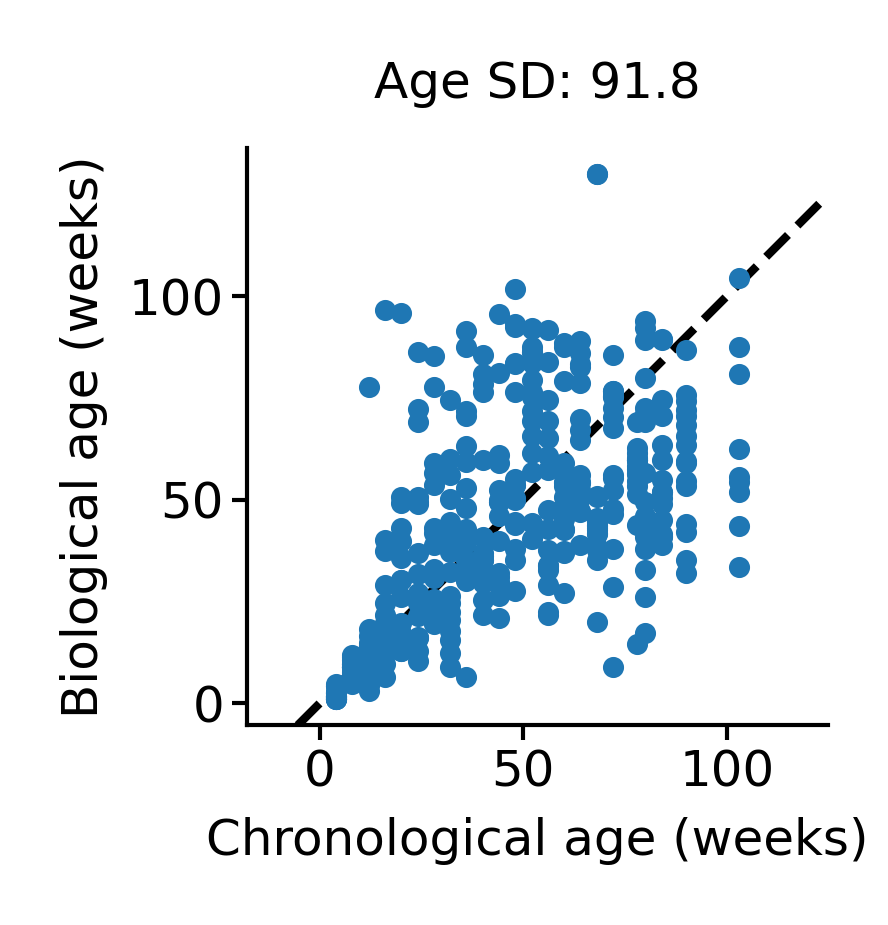

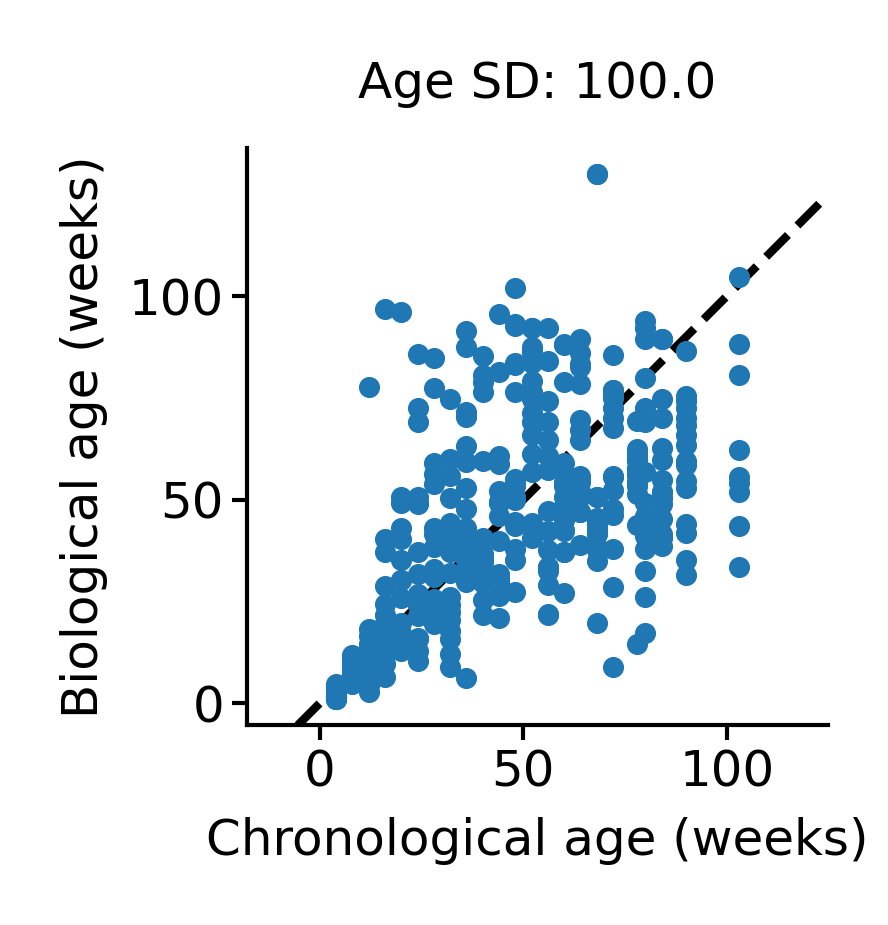

In [20]:
for k, v in bio_ages.items():
    fig = figure(1.25, 1.25)
    plt.scatter(features["ages"], v[0], s=3)
    plt.xlabel("Chronological age (weeks)")
    plt.ylabel("Biological age (weeks)")
    plt.title(f"Age SD: {k:0.1f}")
    add_identity(fig.gca(), c='k', ls='--', zorder=-1)
    plt.axis('equal')
    sns.despine()

In [21]:
pd.DataFrame(lls).mean().sort_values(ascending=False)

26.500000    -199142.8
18.333333    -199145.6
34.666667    -199174.8
42.833333    -199216.4
51.000000    -199259.6
10.166667    -199261.8
59.166667    -199301.2
67.333333    -199339.6
75.500000    -199374.8
2.000000     -199385.0
83.666667    -199407.6
91.833333    -199437.8
100.000000   -199466.4
dtype: float64

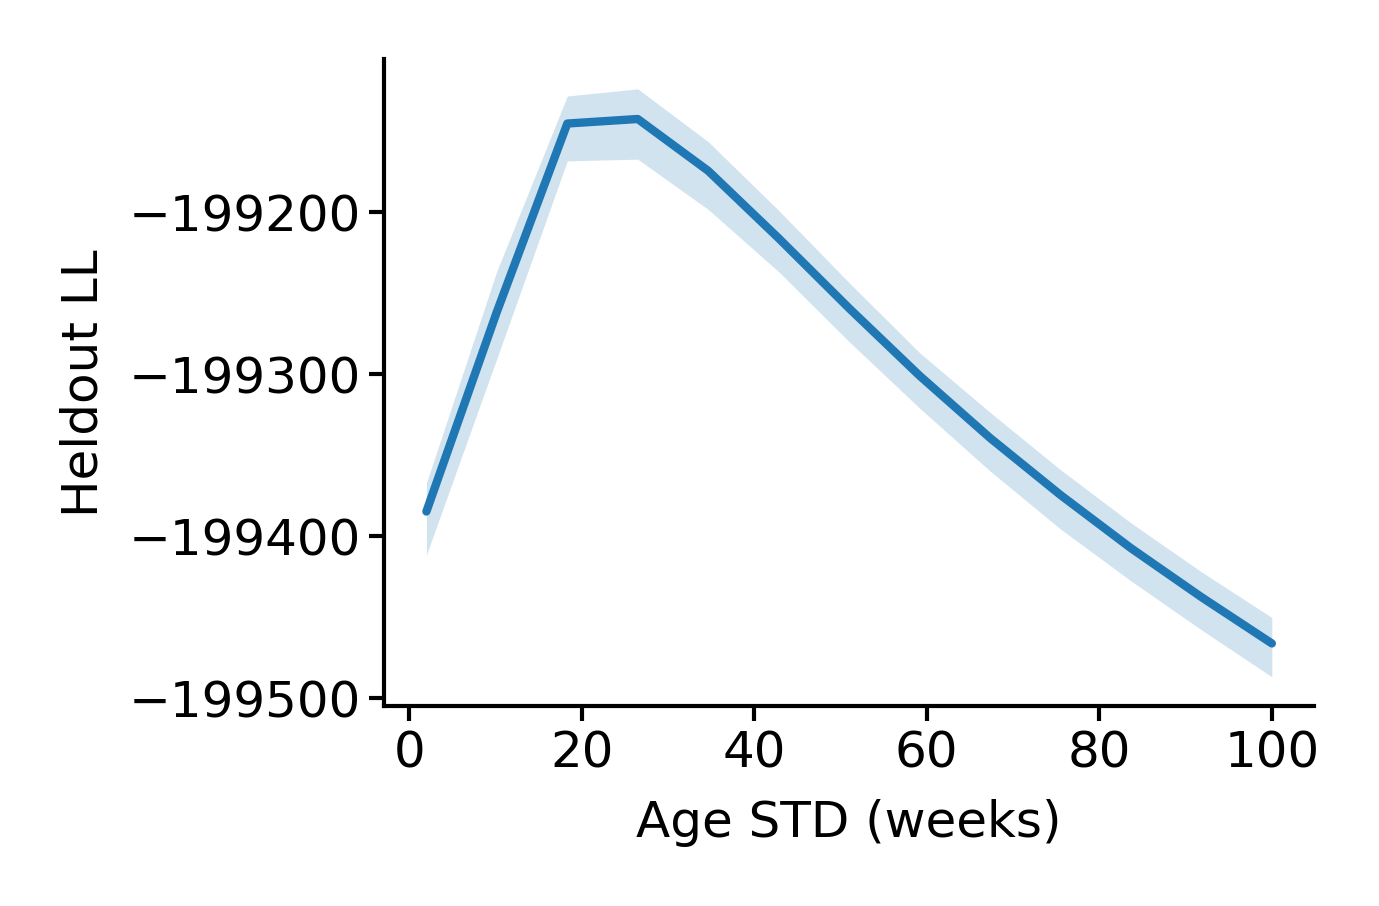

In [22]:
figure(2, 1.4)
ax = sns.lineplot(
    data=pd.DataFrame(lls).melt(var_name="age_sd", value_name="hll"),
    x="age_sd",
    y="hll",
    err_kws={"lw": 0},
)
ax.set(xlabel="Age STD (weeks)", ylabel="Heldout LL")
sns.despine()

## Add mouse size into fitting procedure

In [17]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 10,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 500,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 15,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 125,
}

lls = {}
bio_ages = {}
# for n_splines in tqdm(range(4, 8, 1)):
for age_sd in tqdm(list(map(float, np.linspace(2, 80, 11)))):
    # hypparams["n_splines"] = n_splines
    hypparams["age_sd"] = age_sd
    output = masked_xval(features, hypparams, model_version=1, n_repeats=4)
    hll = list(pluck('heldout_ll', output.values()))
    # lls[n_splines] = np.array(hll)
    lls[age_sd] = np.array(hll)
    bio_ages[age_sd] = list(pluck("bio_ages", output.values()))

  0%|          | 0/11 [00:00<?, ?it/s]

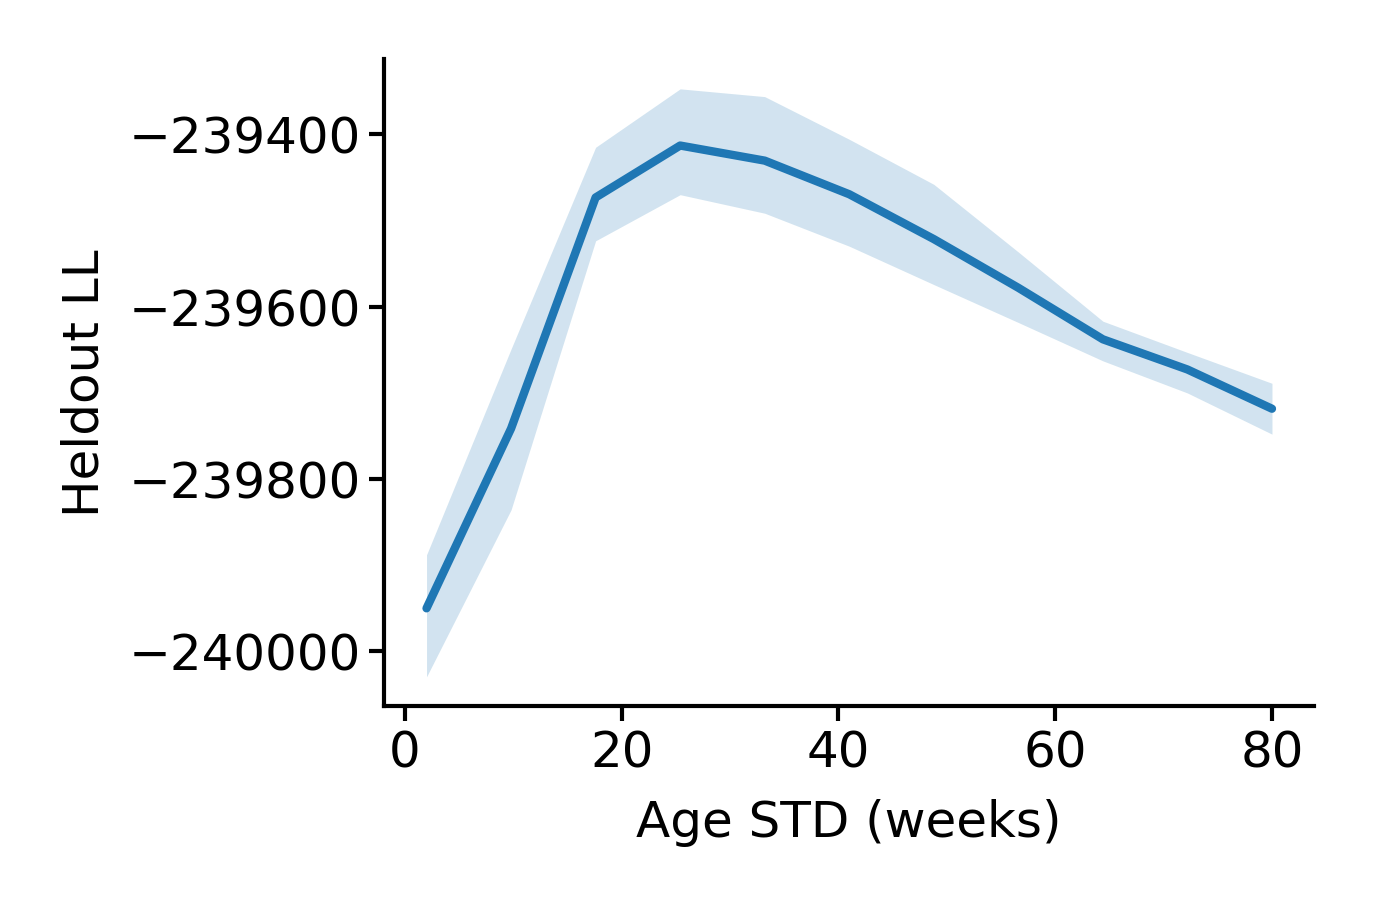

In [18]:
figure(2, 1.4)
ax = sns.lineplot(
    data=pd.DataFrame(lls).melt(var_name="age_sd", value_name="hll"),
    x="age_sd",
    y="hll",
    err_kws={"lw": 0},
)
ax.set(xlabel="Age STD (weeks)", ylabel="Heldout LL")
sns.despine()

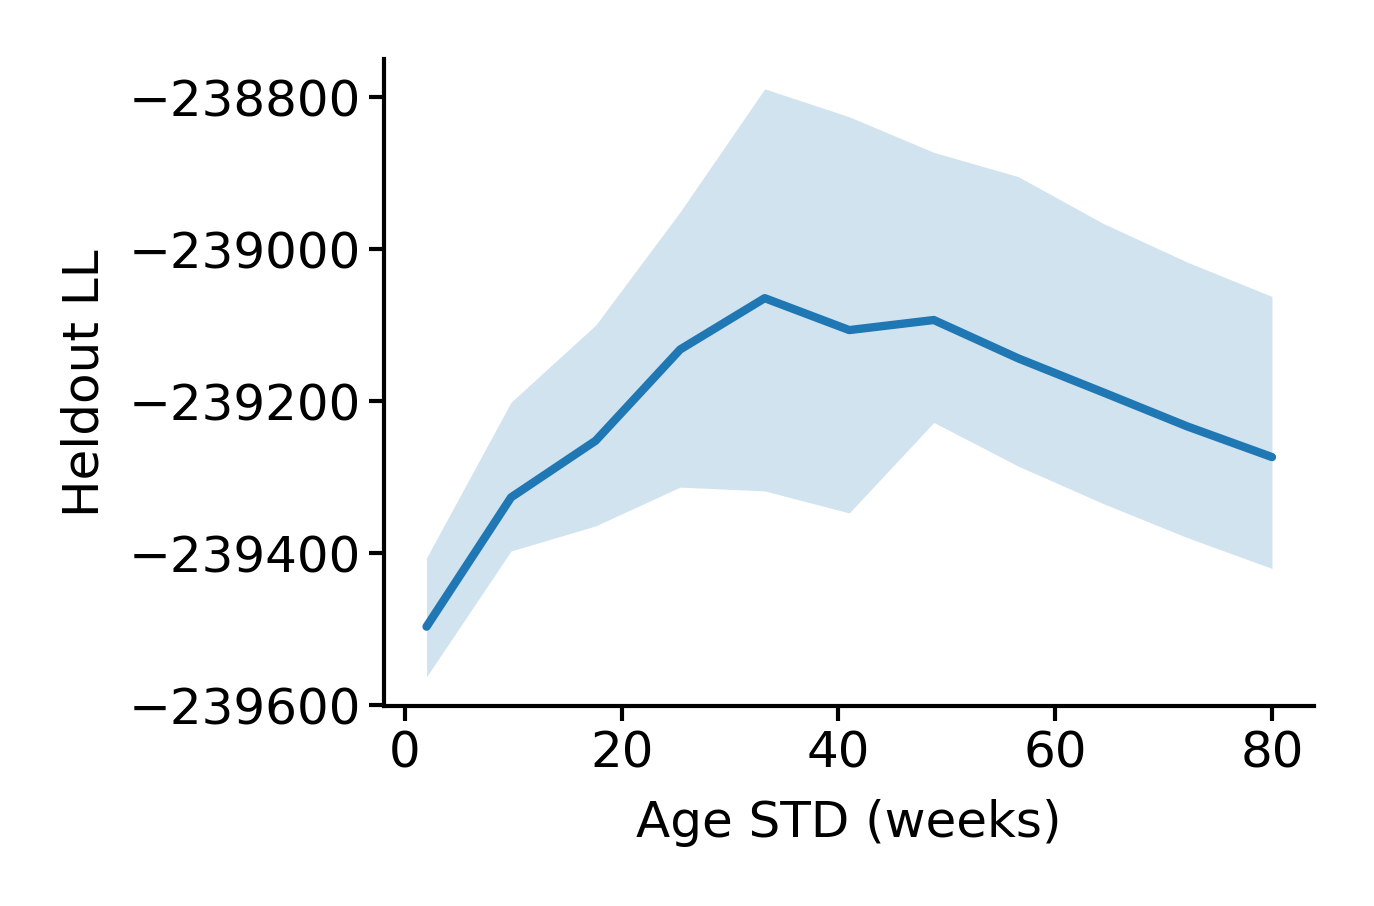

In [16]:
figure(2, 1.4)
ax = sns.lineplot(
    data=pd.DataFrame(lls).melt(var_name="age_sd", value_name="hll"),
    x="age_sd",
    y="hll",
    err_kws={"lw": 0},
)
ax.set(xlabel="Age STD (weeks)", ylabel="Heldout LL")
sns.despine()

In [17]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
    "sizes": sizes_col.to_numpy(),
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 20,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 500,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_syllables": n_syllables,
    "n_keep_sylls": 40,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 125,
}

output = stratified_xval(features, hypparams, model_version=2, n_folds=5)

In [18]:
m2_lls = list(pluck('heldout_ll', output.values()))

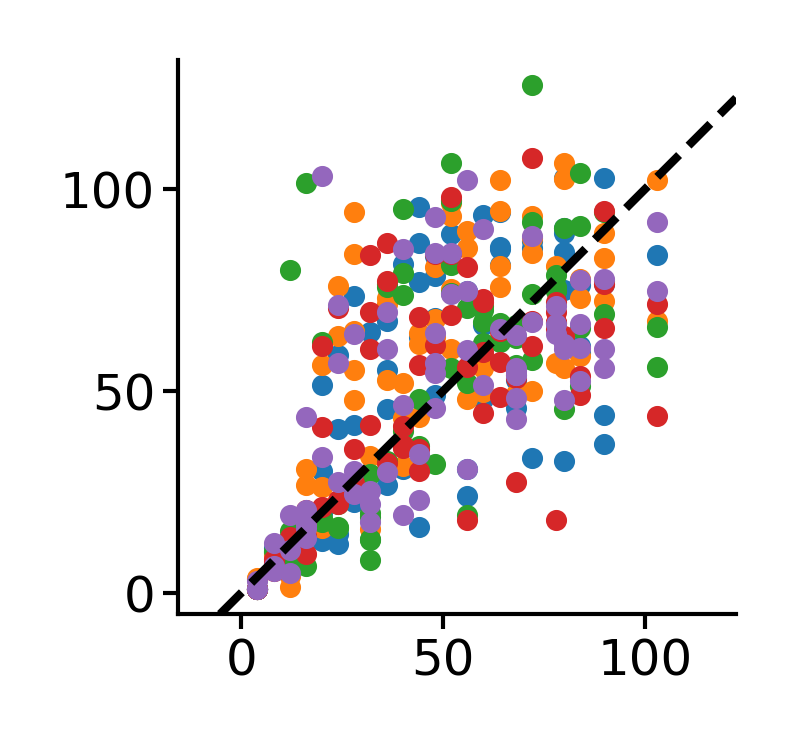

In [12]:
fig = figure(1.2, 1.2)
for k, v in output.items():
    plt.scatter(v['true_ages'], v['bio_ages'], s=3)
add_identity(plt.gca(), ls='--', c='k')
plt.axis('equal')
sns.despine()

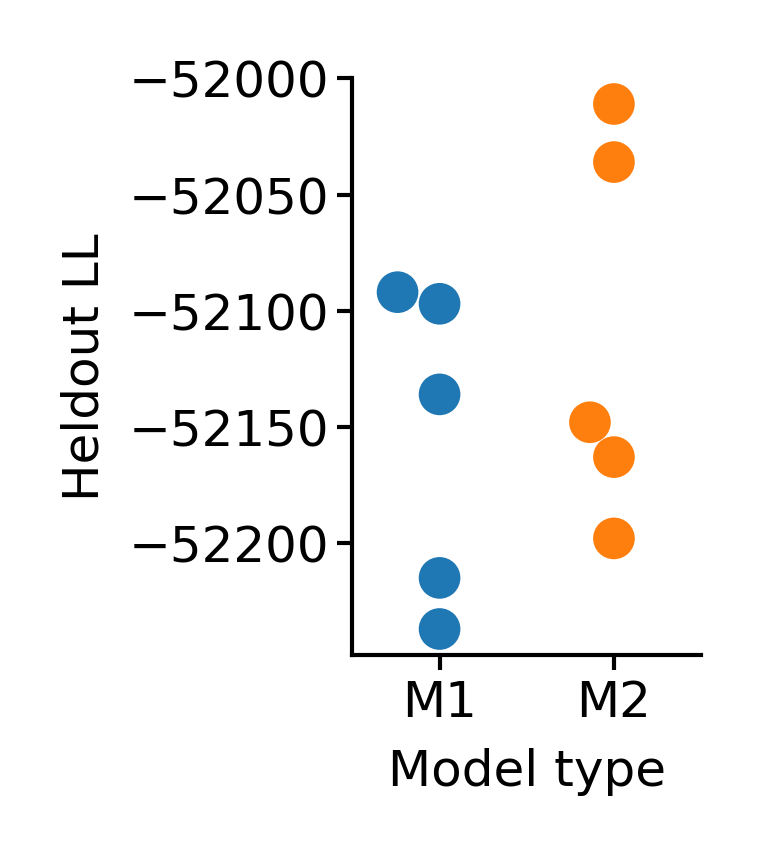

In [24]:
fig = figure(0.75, 1.25)
ax = sns.swarmplot(data=[m1_lls, m2_lls])
ax.set(xticklabels=["M1", "M2"], ylabel="Heldout LL", xlabel="Model type")
sns.despine()

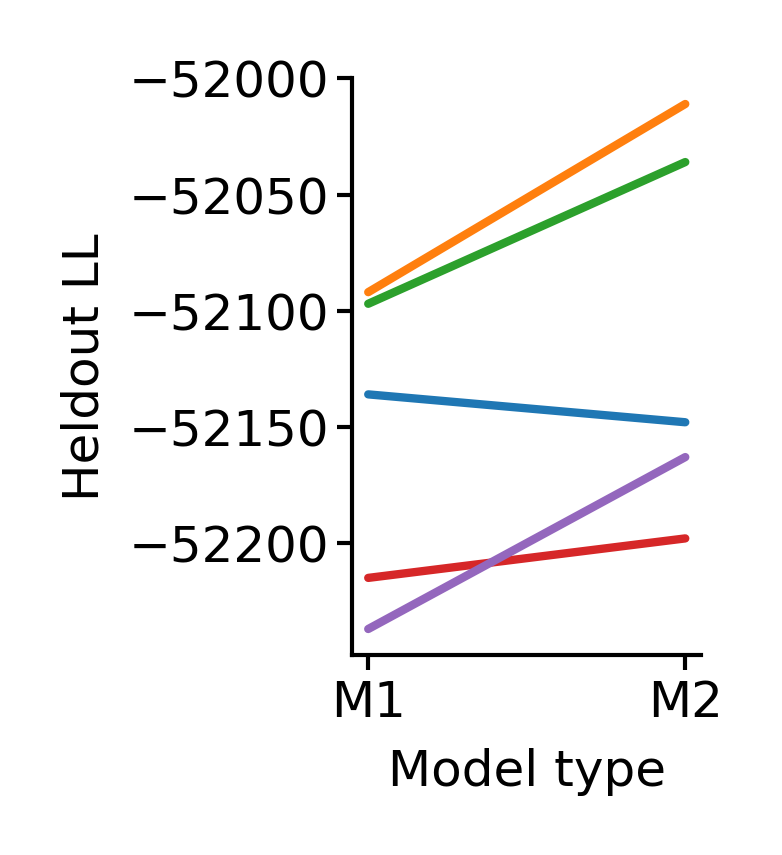

In [27]:
fig = figure(0.75, 1.25)
ax = fig.gca()
for x, y in zip(m1_lls, m2_lls):
    ax.plot([0, 1], [x, y])
ax.set(
    xticks=[0, 1], xticklabels=["M1", "M2"], ylabel="Heldout LL", xlabel="Model type"
)

## Run for individuality

In [28]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_males_relabeled_counts_matrix_v00.parquet"
    # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)
mask = df.index.get_level_values("age") < 100
df = df[mask].copy()

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_v2_males_mouse_area_df_v00.parquet'
    # '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_mouse_area_df_v00.parquet'
)

# sizes_col = size_df.groupby('age')['quant_0.5'].transform(demean)
# sizes_col = size_df.groupby('age')['quant_0.5'].transform(zscore)
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.loc[df.index]

sizes_col.loc[sizes_col == 0] = np.nan
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

sizes_col = sizes_col.loc[df.index]

label_encoder = OneHotEncoder(sparse_output=False, dtype=np.float32)
mouse_ids = label_encoder.fit_transform(
    sizes_col.index.get_level_values("mouse").to_numpy()[:, None]
).T

In [29]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    "mice": mouse_ids,  # models > 2
}

hypparams = {
    "min_age": 1,
    "max_age": age.max() + 5,
    "age_sd": 10,  # weeks
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
    "n_age_samples": 1000,
    "n_splines": 5,
    "n_size_splines": 5,
    "n_development_splines": 9,
    "n_syllables": n_syllables,
    "n_keep_sylls": 13,
    "n_sessions": len(syllable_counts_jax),
    "n_animals": len(mouse_ids),
    "lr": 0.2,
    "n_opt_iter": 150,
}

In [31]:
output = stratified_xval(features, hypparams, model_version=3, n_folds=5)

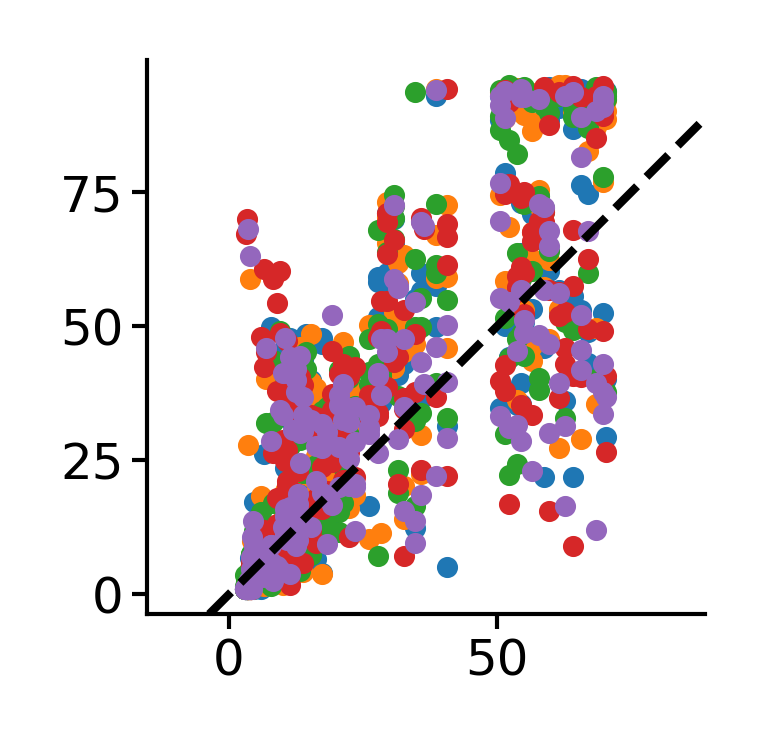

In [32]:
fig = figure(1.2, 1.2)
for k, v in output.items():
    plt.scatter(v['true_ages'], v['bio_ages'], s=3)
add_identity(plt.gca(), ls='--', c='k')
plt.axis('equal')
sns.despine()

In [33]:
output = stratified_xval(features, hypparams, model_version=4, n_folds=5)

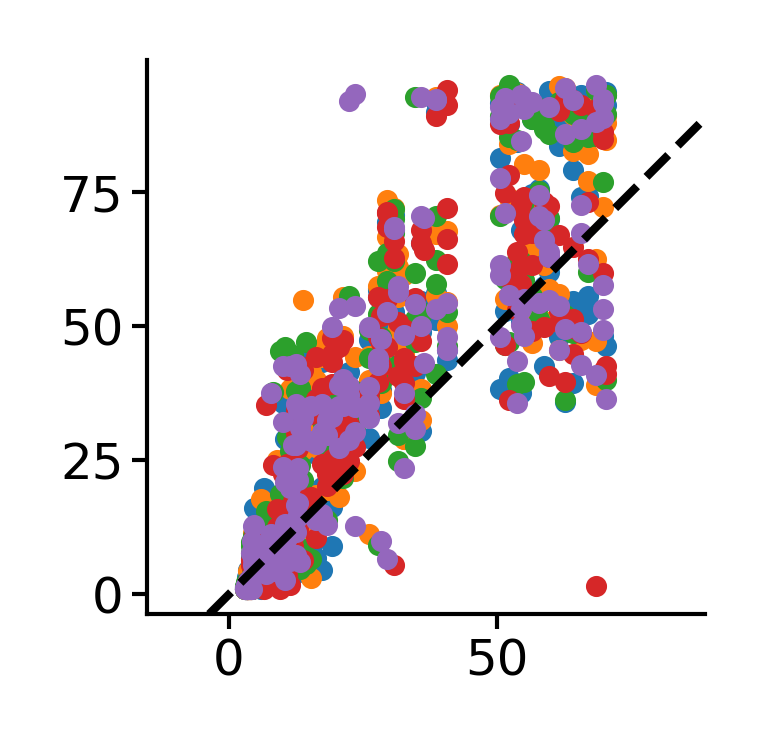

In [34]:
fig = figure(1.2, 1.2)
for k, v in output.items():
    plt.scatter(v['true_ages'], v['bio_ages'], s=3)
add_identity(plt.gca(), ls='--', c='k')
plt.axis('equal')
sns.despine()

In [9]:
output = stratified_xval(features, hypparams, model_version=5, n_folds=5)

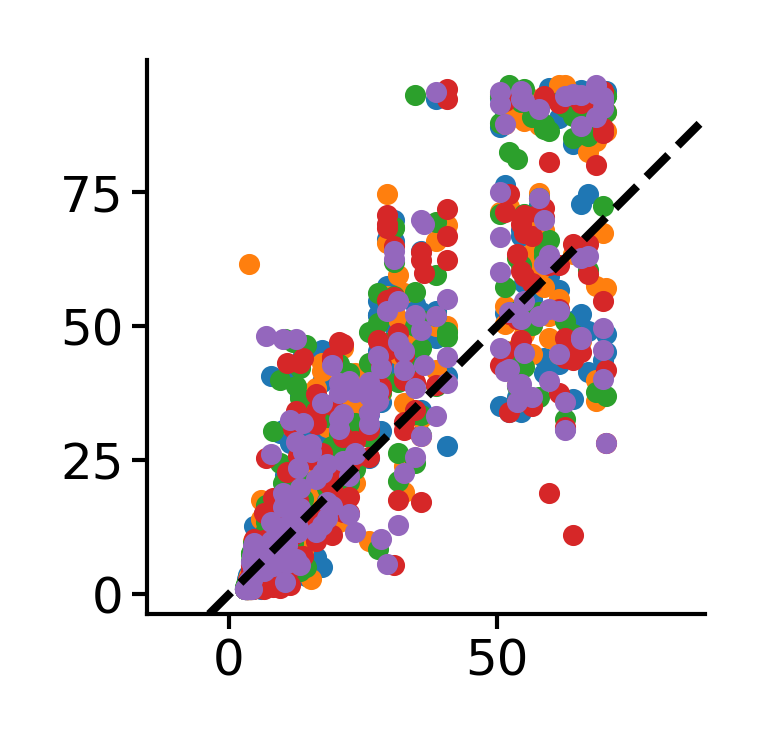

In [53]:
fig = figure(1.2, 1.2)
for k, v in output.items():
    plt.scatter(v['true_ages'], v['bio_ages'], s=3)
add_identity(plt.gca(), ls='--', c='k')
plt.axis('equal')
sns.despine()

In [20]:
output = masked_xval(features, hypparams, model_version=5, n_repeats=4)

In [38]:
# TODO: try optimizing dev weights and age sd simultaneously

In [ ]:
lls = {}
r2s = {}
for nsp in tqdm(range(4, 21)):
    hypparams['n_development_splines'] = nsp
    output = masked_xval(features, hypparams, model_version=5, n_repeats=5)
    lls[nsp] = list(pluck('heldout_ll', output.values()))
    r2s[nsp] = list(pluck('heldout_r2_total', output.values()))
ll_df = pd.DataFrame(lls)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
r2_df = pd.DataFrame(r2s)

In [ ]:
ll_df.mean().sort_values()

In [ ]:
fig = figure(0.8, 1)
ax = sns.lineplot(data=ll_df.melt(), x='variable', y='value', size=2.25)
ax.set(xlabel="N splines", ylabel="Heldout LL")
sns.despine()

In [ ]:
fig = figure(0.8, 1)
ax = sns.lineplot(data=r2_df.melt(), x='variable', y='value', size=2.25)
ax.set(xlabel="N splines", ylabel="R2")
sns.despine()

In [ ]:
list(output[0]['concentration_components'])

In [ ]:
list(output[0]['params'])

In [ ]:
output[0]['params']['development_weights']

In [ ]:
fig = figure(1.7, 1)

for k in output:
    p = output[k]["params"]
    # bias_scale = (jnp.exp(p["development_weights"]) @ output[k]['init_components'].bases['development']).flatten()
    bias_scale = output[k]['concentration_components']['indiv_scale']
    plt.plot(
        np.linspace(hypparams["min_age"], hypparams["max_age"], hypparams["n_age_samples"]),
        bias_scale
    )

# plt.ylim(0, 1)
plt.xlim(0, None)
plt.xlabel("Bio age (weeks)")
plt.ylabel("Individuality influence")
sns.despine()

In [24]:
hypparams['n_development_splines'] = 9
output = masked_xval(features, hypparams, model_version=5, n_repeats=4)

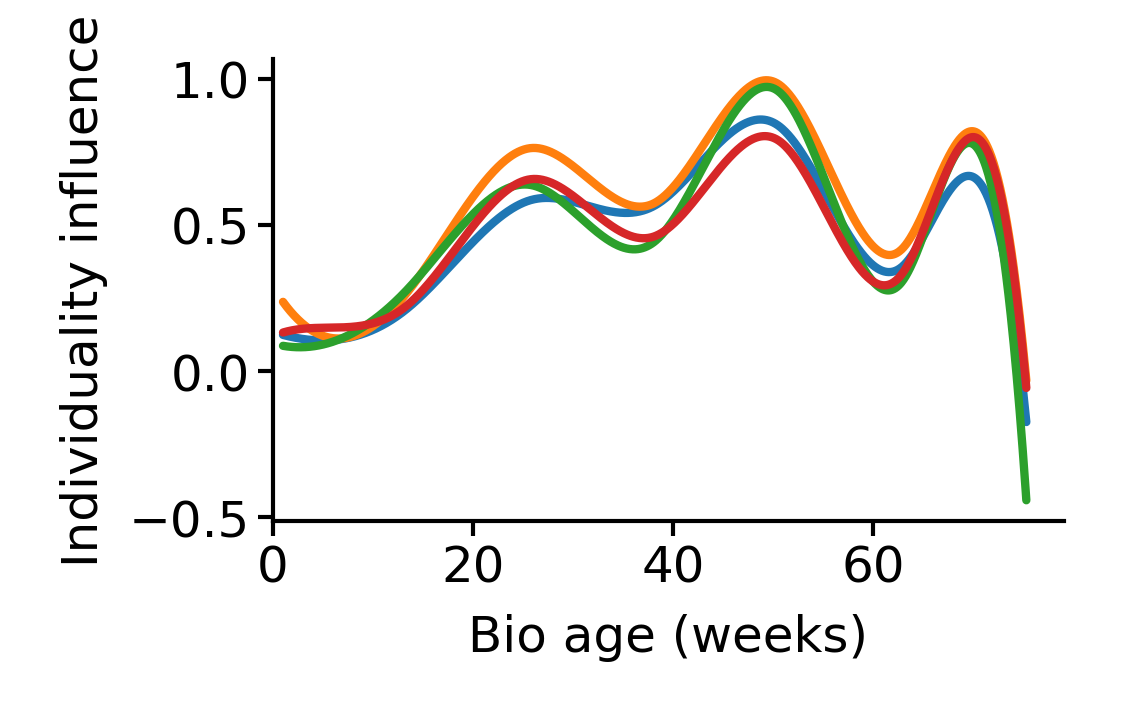

In [27]:
fig = figure(1.7, 1)

for k in output:
    p = output[k]["params"]
    bias_scale = output[k]['concentration_components']['indiv_scale']
    plt.plot(
        np.linspace(hypparams["min_age"], hypparams["max_age"], hypparams["n_age_samples"]),
        bias_scale
    )

# plt.ylim(0, 1)
plt.xlim(0, None)
plt.xlabel("Bio age (weeks)")
plt.ylabel("Individuality influence")
sns.despine()

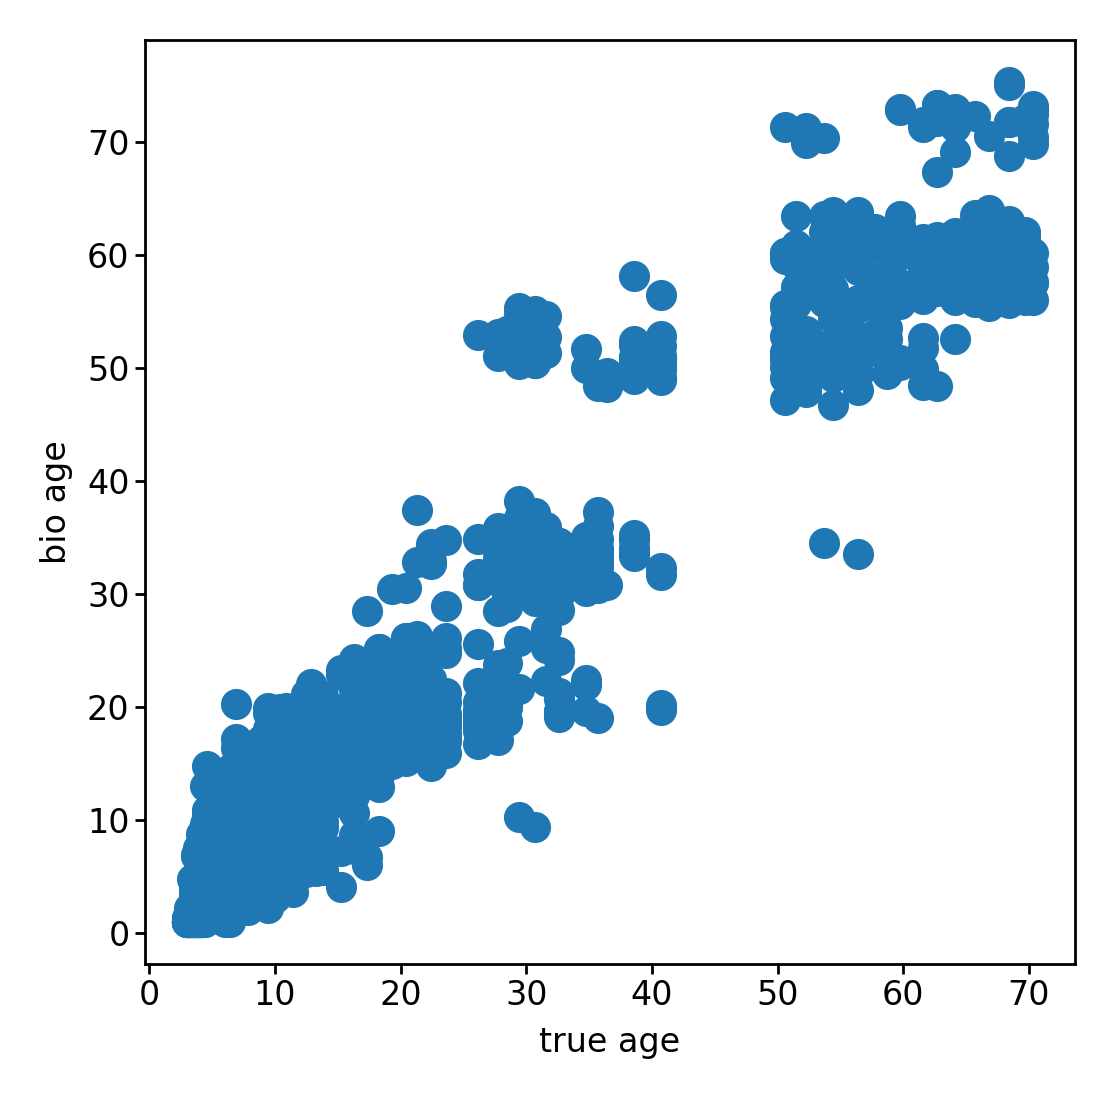

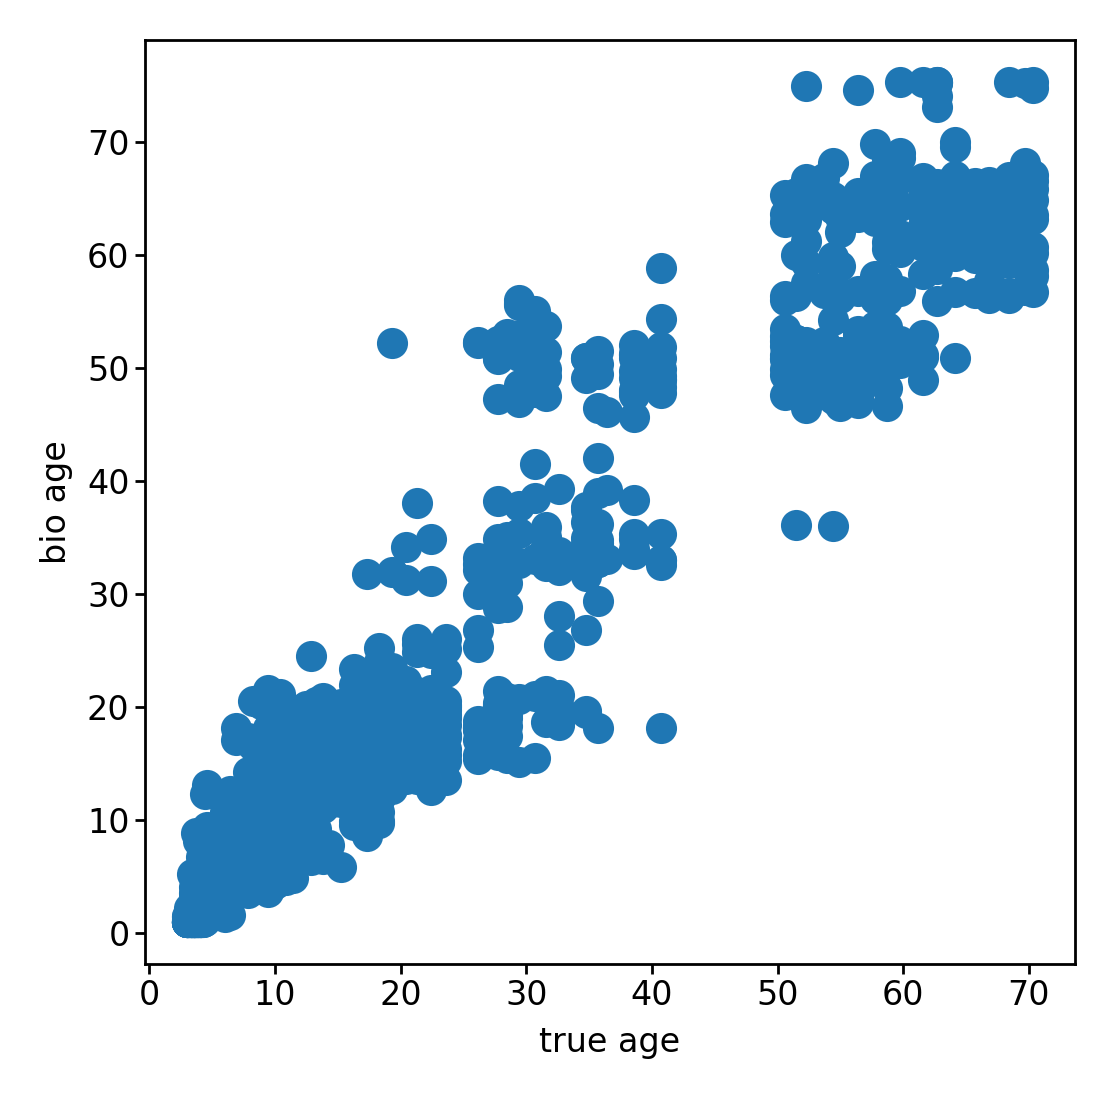

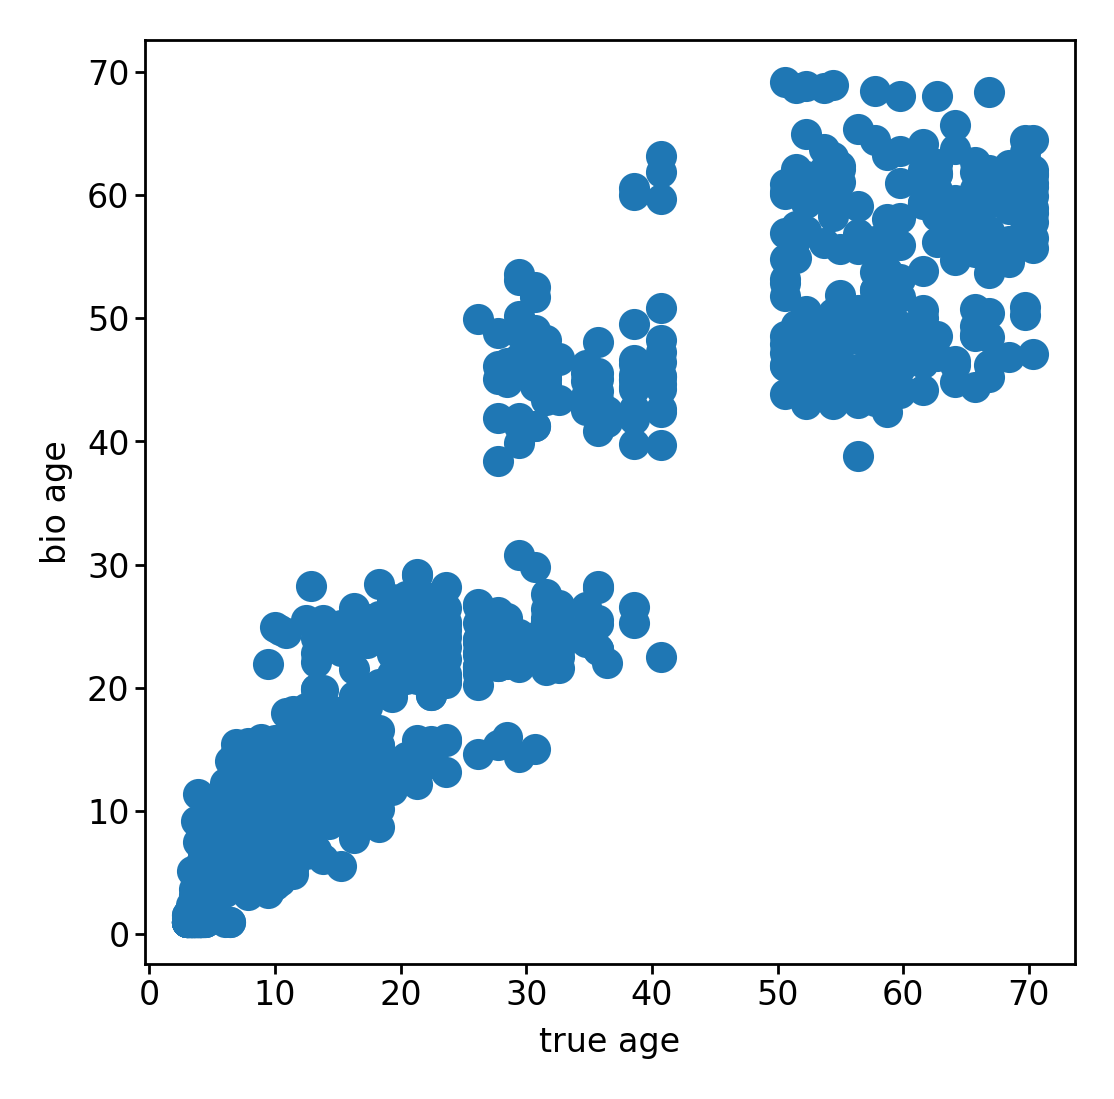

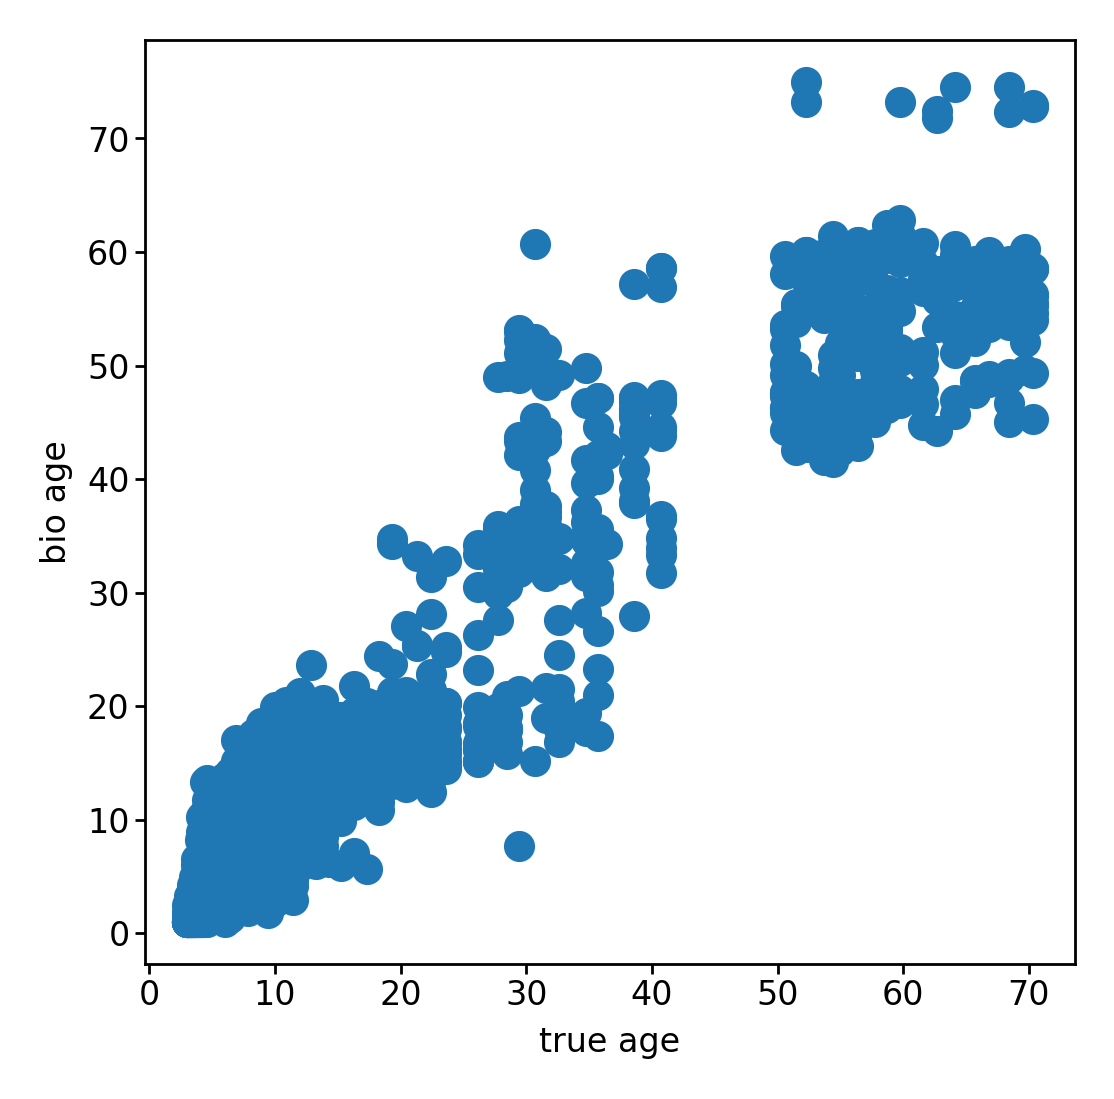

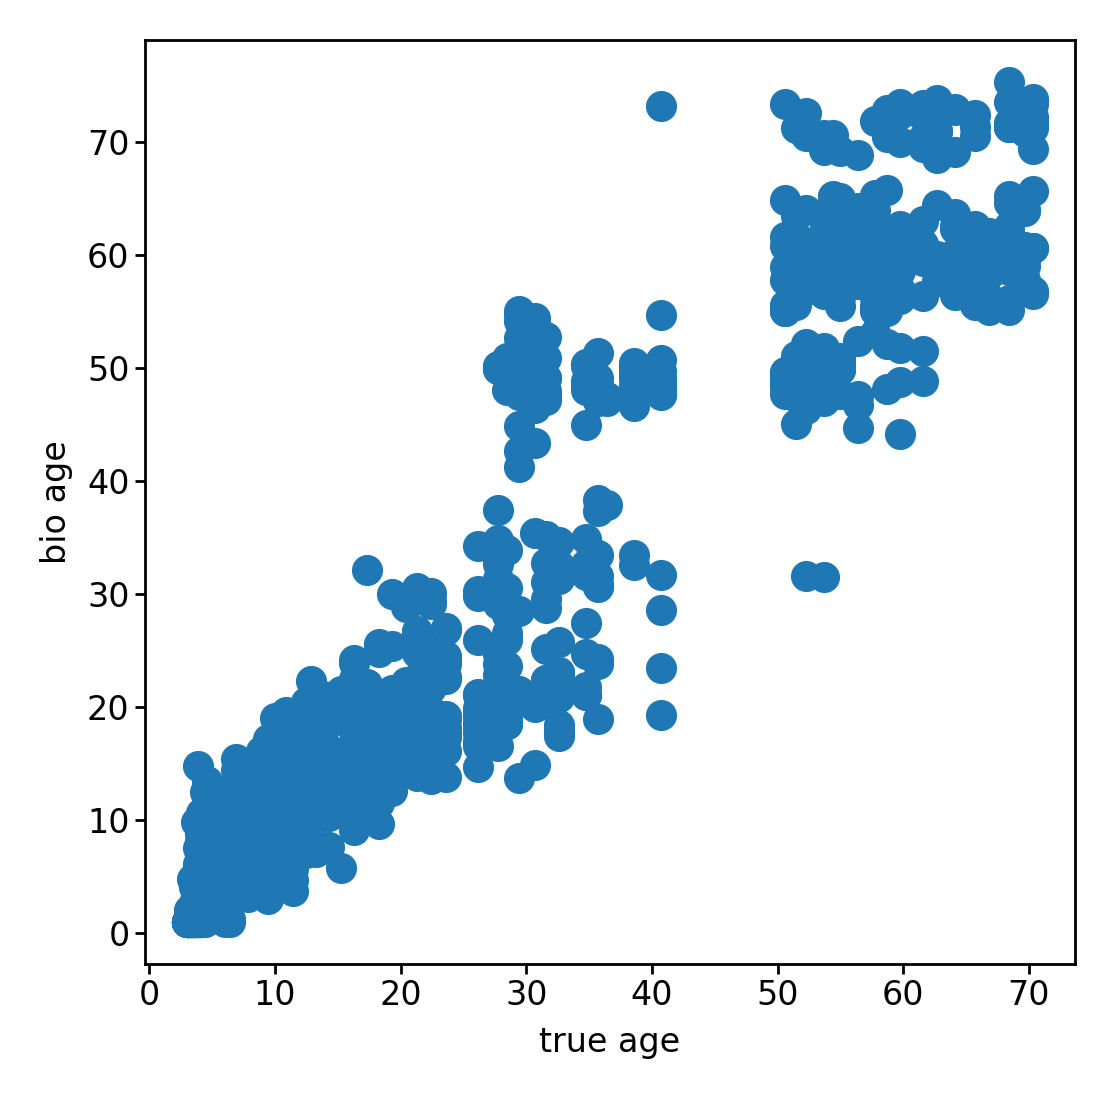

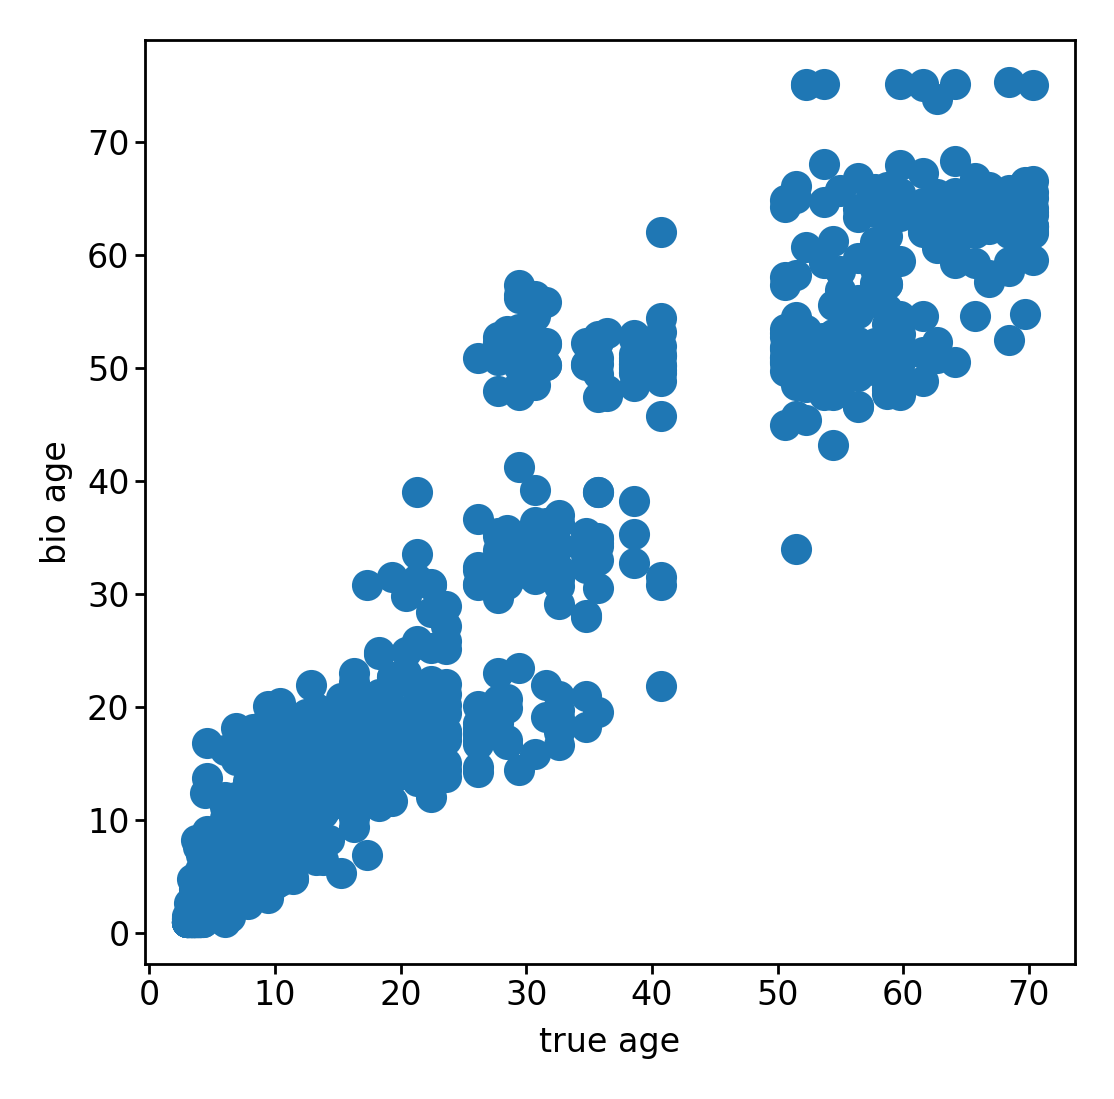

In [13]:
for k, v in output.items():
    plt.figure()
    plt.scatter(v['true_ages'], v['bio_ages'])
    plt.xlabel("true age")
    plt.ylabel("bio age")

## What is different between v3 and v5?

In [34]:
hypparams['n_development_splines'] = 7
output_v5 = masked_xval(features, hypparams, model_version=5, n_repeats=4)
output_v3 = masked_xval(features, hypparams, model_version=3, n_repeats=4)

Text(0, 0.5, 'bio age')

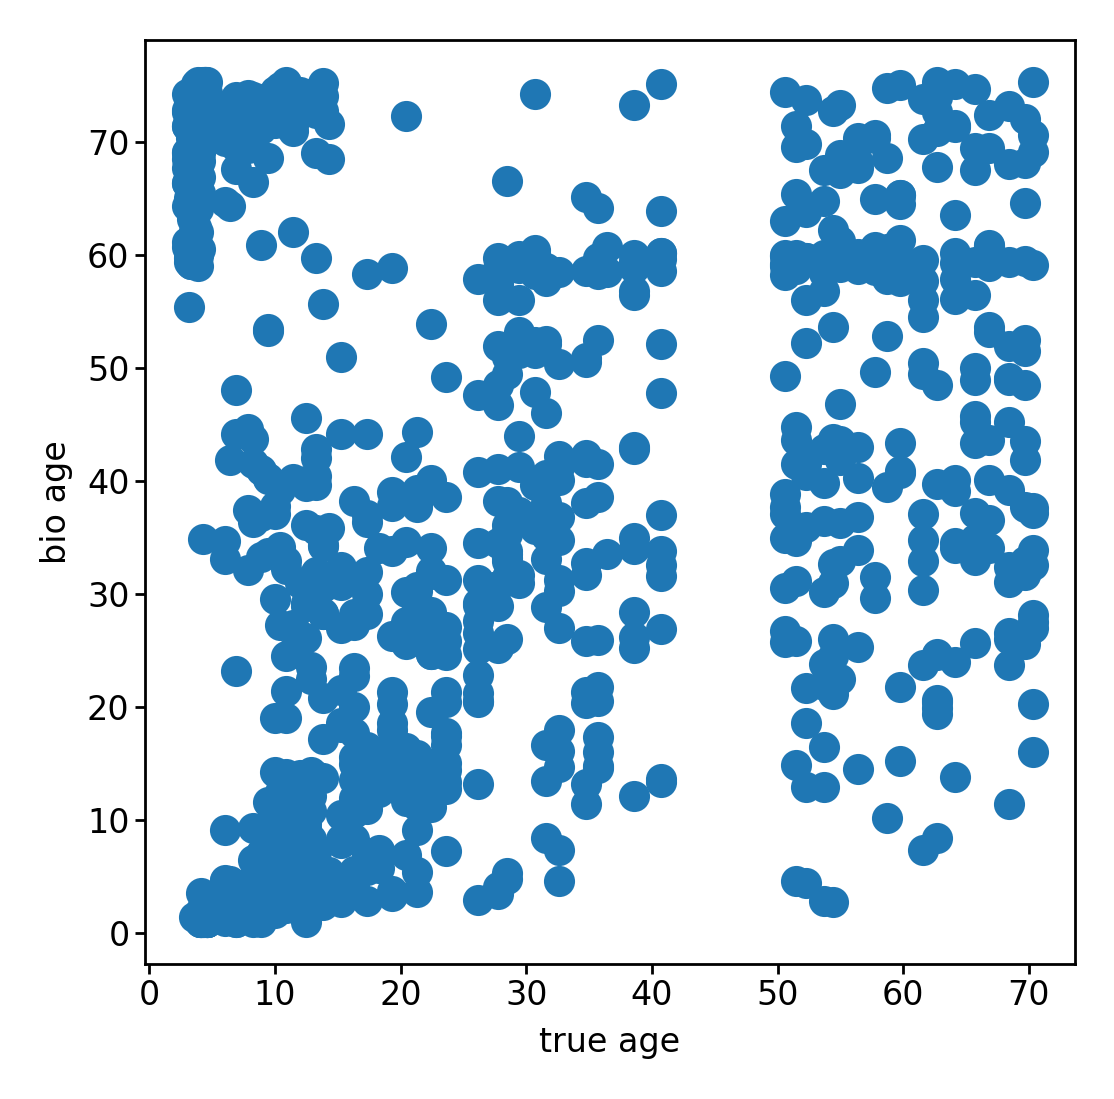

In [35]:
v = output_v3[0]
plt.figure()
plt.scatter(v['true_ages'], v['bio_ages'])
plt.xlabel("true age")
plt.ylabel("bio age")

In [37]:
indiv = df.index.get_level_values('mouse')

In [40]:
age_df = pd.DataFrame({'bio': v['bio_ages'], 'chron': v['true_ages']}, index=indiv)

<Axes: xlabel='chron'>

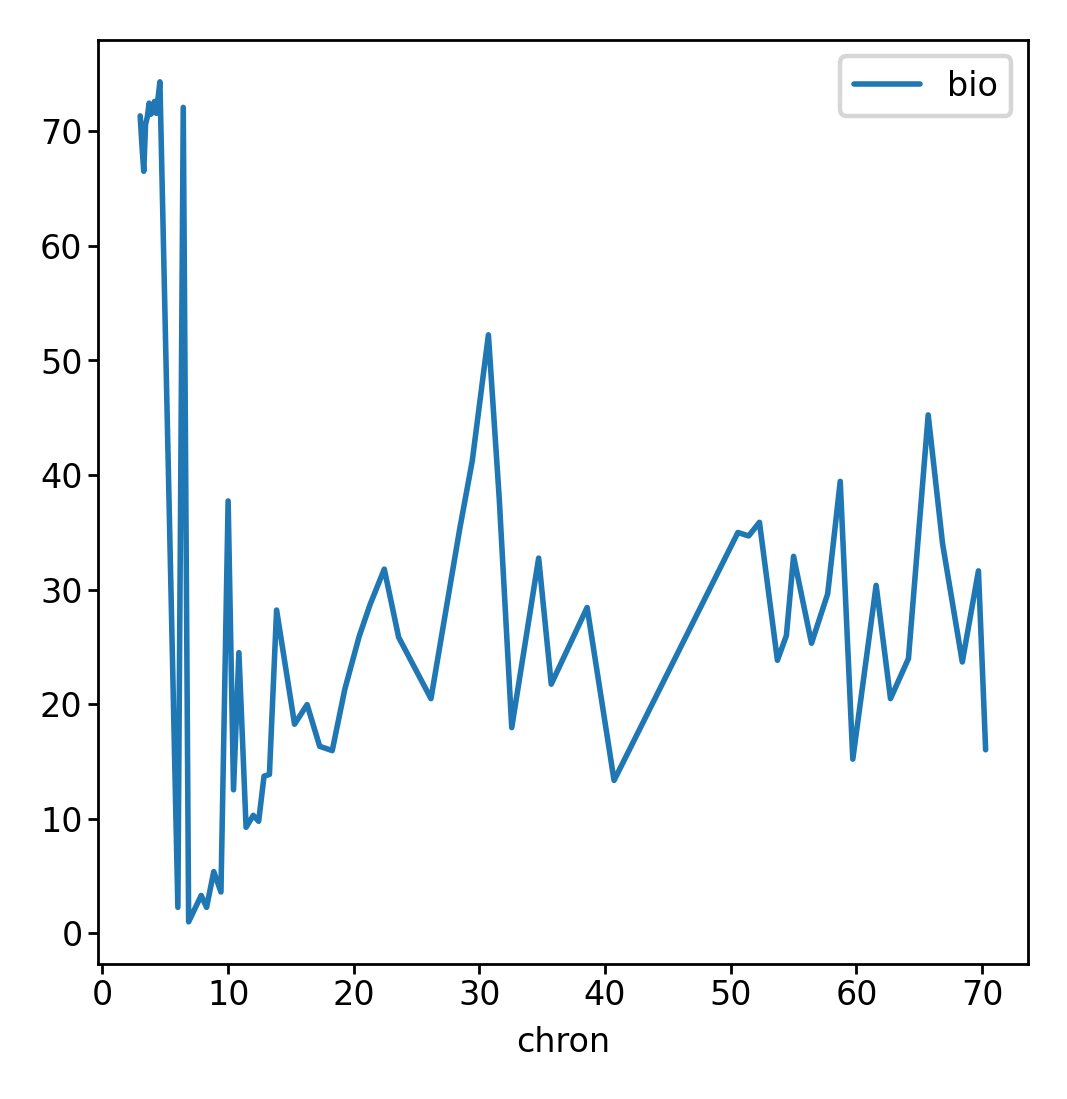

In [41]:
age_df.loc['01_01'].plot(x='chron', y='bio')

In [6]:
lls = {}
r2s = {}
for model in tqdm(range(0, 6)):
    if model == 0:
        hypparams['bio_params_sd'] = 10
    else:
        hypparams['bio_params_sd'] = 0.3
    output = masked_xval(features, hypparams, model_version=model, n_repeats=4)
    lls[model] = list(pluck('heldout_ll', output.values()))
    r2s[model] = list(pluck('heldout_r2_total', output.values()))
    print(lls[model])
    print(r2s[model])
ll_df = pd.DataFrame(lls)
r2_df = pd.DataFrame(r2s)

  0%|          | 0/6 [00:00<?, ?it/s]

[-1151657, -1152714, -1151374, -1151831]
[0.32122159004094497, 0.31230144079133526, 0.322135813867789, 0.3135101197887753]
[-1121851, -1122435, -1121899, -1121796]
[0.4869849221068932, 0.4474128891474287, 0.47898097669821116, 0.4845017695074633]
[-1121893, -1122272, -1121380, -1121207]
[0.45720931800759745, 0.4404159724166871, 0.4801416691463659, 0.49717792450281284]
[-1120073, -1119365, -1119210, -1118747]
[0.5317337445135483, 0.5540723087160093, 0.5450480201748157, 0.5666202591984545]
[-1118424, -1118373, -1118216, -1118292]
[0.5784284447800141, 0.5734191766236046, 0.5613525751336914, 0.5588482764849806]
[-1117380, -1117122, -1117551, -1117529]
[0.5996920900275624, 0.5977995875552233, 0.5791744517535332, 0.5767664682854935]


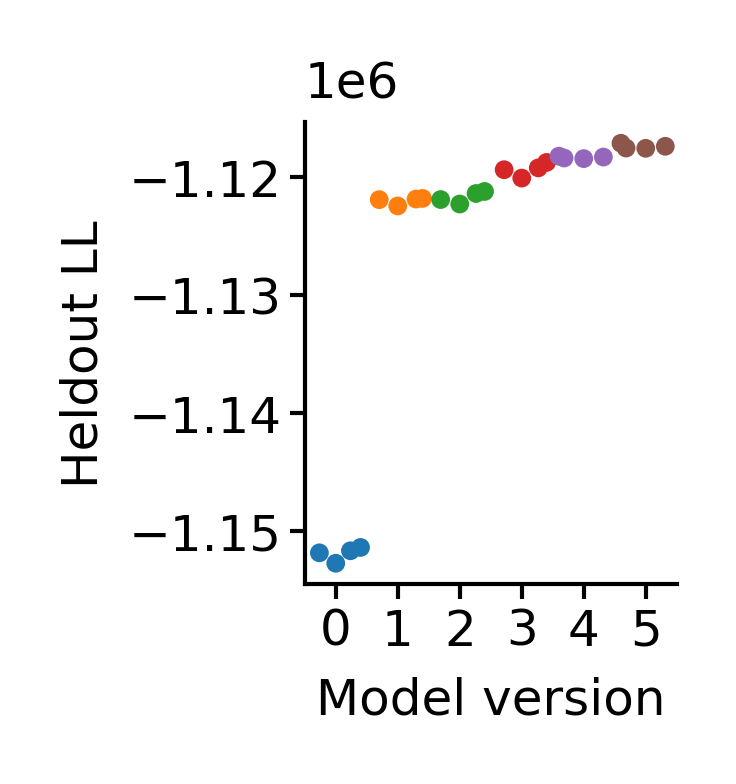

In [7]:
fig = figure(0.8, 1)
ax = sns.swarmplot(data=ll_df, size=2.25)
ax.set(xlabel="Model version", ylabel="Heldout LL")
sns.despine()

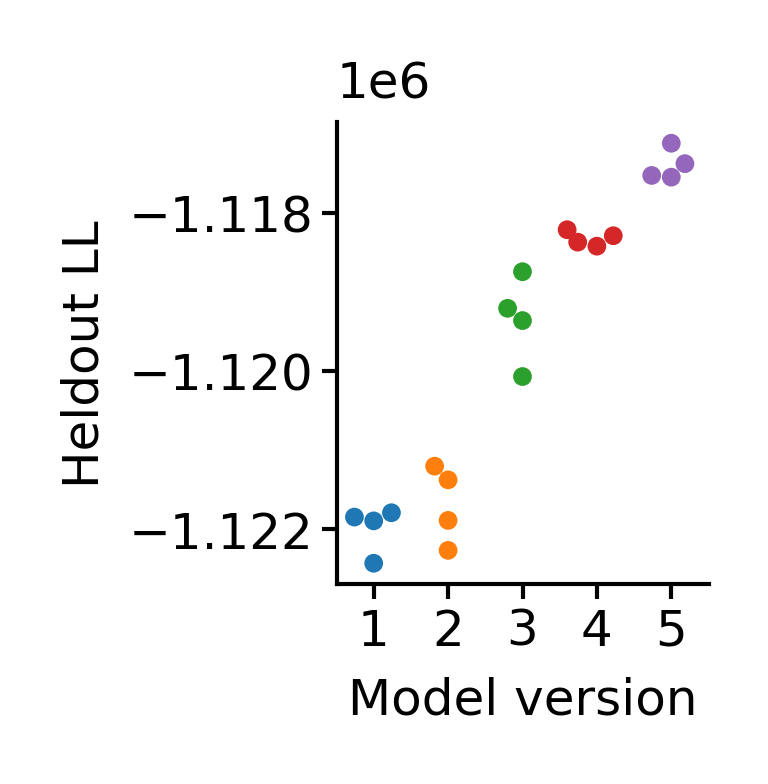

In [8]:
fig = figure(0.8, 1)
ax = sns.swarmplot(data=ll_df.iloc[:, 1:], size=2.25)
ax.set(xlabel="Model version", ylabel="Heldout LL")
sns.despine()

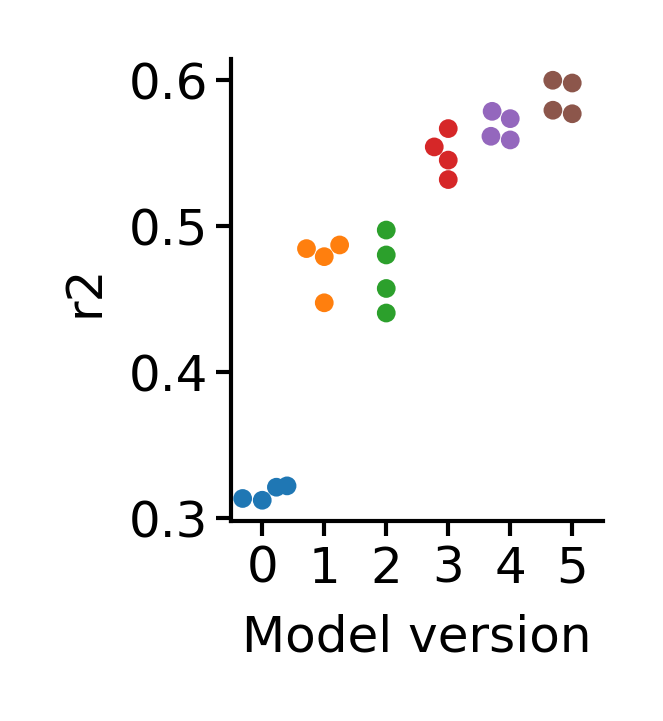

In [9]:
fig = figure(0.8, 1)
ax = sns.swarmplot(data=r2_df, size=2.25)
ax.set(xlabel="Model version", ylabel="r2")
sns.despine()

In [28]:
fig = figure(1.7, 1)

for k in output:
    p = output[k]["params"]
    bias_scale = (jnp.exp(p["development_weights"]) @ output[k]['init_components'].bases['development']).flatten()
    plt.plot(
        np.linspace(hypparams["min_age"], hypparams["max_age"], hypparams["n_age_samples"]),
        bias_scale
    )

# plt.ylim(0, None)
# plt.xlim(0, None)
plt.xlabel("Bio age (weeks)")
plt.ylabel("Individuality influence")
sns.despine()

KeyError: 'development'

<Figure size 510x300 with 0 Axes>